# 0.0 IMPORTS

In [719]:
import pandas as pd
import numpy as np
import seaborn as sns
import sweetviz as sv
import xgboost as xgb
import random
import math
from boruta                import BorutaPy

from sklearn.preprocessing import MinMaxScaler
from matplotlib            import pyplot as plt
from scipy                 import stats as ss
from sklearn import preprocessing
from sklearn import model_selection as ms
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import PowerTransformer


# 0.1. LOADING DATA

In [740]:
data_raw = pd.read_csv( '/Users/thiago/Thiago/Data_Science/myrepos/mobility_cars_hack02/mobilitycars_data/treino.csv')

In [741]:
data_raw.columns.size

29

In [742]:
data_raw.head()

ID  num_fotos       marca  modelo  \
0  105869496634249611881157692933406072990        8.0  VOLKSWAGEN  AMAROK   
1   14165644411757892901957277406025007093        8.0      JAGUAR  F-PACE   
2   78515656948521351316652580664682810356       14.0   CHEVROLET   CRUZE   
3   36797041166808090517929207429817328298        8.0     PORSCHE     718   
4  338618517701891995317200439137014723900        8.0       VOLVO    XC90   

                                              versao  ano_de_fabricacao  \
0  2.0 TRENDLINE 4X4 CD 16V TURBO INTERCOOLER DIE...               2017   
1    2.0 16V TURBO DIESEL PRESTIGE AWD 4P AUTOMÁTICO               2017   
2                      1.8 LT 16V FLEX 4P AUTOMÁTICO               2012   
3                    2.0 16V H4 GASOLINA BOXSTER PDK               2020   
4   2.0 INSCRIPTION TURBO GASOLINA 4P 4X4 AUTOMÁTICO               2015   

   ano_modelo  odometro      cambio  num_portas  ... elegivel_revisao  \
0      2017.0   55672.0  Automática           4  ...            False   
1      2017.0   47858.0  Automática           4  ...            False   
2      2013.0  122323.0  Automática           4  ...            False   
3      2021.0   14207.0  Automática           2  ...            False   
4      2016.0   43760.0  Automática           4  ...            False   

  attr_veiculo_aceita_troca attr_veiculo_único_dono  \
0              Aceita troca                     NaN   
1              Aceita troca                     NaN   
2              Aceita troca                     NaN   
3              Aceita troca                     NaN   
4              Aceita troca                     NaN   

  attr_veiculo_todas_as_revisões_feitas_pela_concessionária  \
0       Todas as revisões feitas pela concessionária          
1       Todas as revisões feitas pela concessionária          
2                                                NaN          
3       Todas as revisões feitas pela concessionária          
4       Todas as revisões feitas pela concessionária          

  attr_veiculo_ipva_pago attr_veiculo_licenciado  \
0              IPVA pago              Licenciado   
1              IPVA pago                     NaN   
2                    NaN                     NaN   
3                    NaN                     NaN   
4                    NaN                     NaN   

  attr_veiculo_garantia_de_fábrica  \
0                              NaN   
1                              NaN   
2                              NaN   
3                              NaN   
4                              NaN   

   attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro  \
0      Todas as revisões feitas pela agenda do carro            
1      Todas as revisões feitas pela agenda do carro            
2                                                NaN            
3                                                NaN            
4      Todas as revisões feitas pela agenda do carro            

   attr_veiculo_alienado          preco  
0                    NaN  123231.992782  
1                    NaN  272076.023576  
2                    NaN   53411.539492  
3                    NaN  299697.071937  
4                    NaN  255164.344178  

[5 rows x 29 columns]

## 0.2. Helper Functions

In [743]:
sns.set(rc={'figure.figsize':(17,10)}) # Aumenta o tamanho dos plots no seaborn\


def cv(data, n_repeats, model, verbose = False):
    X = data.drop(['preco', 'id'], axis = 1).copy()
    y = data['preco'].copy()
    
    mae_total = []
    for i in range(n_repeats):
        print("repeticao",i)
        x_train, x_test, y_train, y_test = ms.train_test_split(X,y, test_size = 0.2)
        model.fit(x_train, y_train)
        yhat = model.predict(x_test)
        mae = mean_absolute_error(y_test, yhat)
        mae_total.append(mae)
    
    result = str(round(np.mean(mae_total), 2)) +  ' +/- ' + str(round(np.std(mae_total), 2))
    return pd.DataFrame({'MAE': result}, index = [0])

# 1.0. PASSO 01 - DESCRICAO DOS DADOS

In [744]:
df1 = data_raw

## 1.1. Rename Columns

In [745]:
df1.columns

Index(['ID', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao',
       'attr_veiculo_aceita_troca', 'attr_veiculo_único_dono',
       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fábrica',
       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
       'attr_veiculo_alienado', 'preco'],
      dtype='object')

In [746]:
cols_new = ['id', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao',
       'attr_veiculo_aceita_troca', 'attr_veiculo_unico_dono',
       'attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fabrica',
       'attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro',
       'attr_veiculo_alienado', 'preco']

df1.columns = cols_new

In [747]:
df1.head()

id  num_fotos       marca  modelo  \
0  105869496634249611881157692933406072990        8.0  VOLKSWAGEN  AMAROK   
1   14165644411757892901957277406025007093        8.0      JAGUAR  F-PACE   
2   78515656948521351316652580664682810356       14.0   CHEVROLET   CRUZE   
3   36797041166808090517929207429817328298        8.0     PORSCHE     718   
4  338618517701891995317200439137014723900        8.0       VOLVO    XC90   

                                              versao  ano_de_fabricacao  \
0  2.0 TRENDLINE 4X4 CD 16V TURBO INTERCOOLER DIE...               2017   
1    2.0 16V TURBO DIESEL PRESTIGE AWD 4P AUTOMÁTICO               2017   
2                      1.8 LT 16V FLEX 4P AUTOMÁTICO               2012   
3                    2.0 16V H4 GASOLINA BOXSTER PDK               2020   
4   2.0 INSCRIPTION TURBO GASOLINA 4P 4X4 AUTOMÁTICO               2015   

   ano_modelo  odometro      cambio  num_portas  ... elegivel_revisao  \
0      2017.0   55672.0  Automática           4  ...            False   
1      2017.0   47858.0  Automática           4  ...            False   
2      2013.0  122323.0  Automática           4  ...            False   
3      2021.0   14207.0  Automática           2  ...            False   
4      2016.0   43760.0  Automática           4  ...            False   

  attr_veiculo_aceita_troca attr_veiculo_unico_dono  \
0              Aceita troca                     NaN   
1              Aceita troca                     NaN   
2              Aceita troca                     NaN   
3              Aceita troca                     NaN   
4              Aceita troca                     NaN   

  attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria  \
0       Todas as revisões feitas pela concessionária          
1       Todas as revisões feitas pela concessionária          
2                                                NaN          
3       Todas as revisões feitas pela concessionária          
4       Todas as revisões feitas pela concessionária          

  attr_veiculo_ipva_pago attr_veiculo_licenciado  \
0              IPVA pago              Licenciado   
1              IPVA pago                     NaN   
2                    NaN                     NaN   
3                    NaN                     NaN   
4                    NaN                     NaN   

  attr_veiculo_garantia_de_fabrica  \
0                              NaN   
1                              NaN   
2                              NaN   
3                              NaN   
4                              NaN   

   attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro  \
0      Todas as revisões feitas pela agenda do carro            
1      Todas as revisões feitas pela agenda do carro            
2                                                NaN            
3                                                NaN            
4      Todas as revisões feitas pela agenda do carro            

   attr_veiculo_alienado          preco  
0                    NaN  123231.992782  
1                    NaN  272076.023576  
2                    NaN   53411.539492  
3                    NaN  299697.071937  
4                    NaN  255164.344178  

[5 rows x 29 columns]

## 1.2. Data Dimensions

In [453]:
print( 'Number of rows:{}'.format( df1.shape[0]))
print( 'Number of columns:{}'.format( df1.shape[1]))

Number of rows:39446
Number of columns:29


## 1.3. Data Types

In [454]:
df1.dtypes

id                                                             object
num_fotos                                                     float64
marca                                                          object
modelo                                                         object
versao                                                         object
ano_de_fabricacao                                               int64
ano_modelo                                                    float64
odometro                                                      float64
cambio                                                         object
num_portas                                                      int64
tipo                                                           object
blindado                                                       object
cor                                                            object
tipo_vendedor                                                  object
cidade_vendedor     

## 1.4. Check NA

In [455]:
df1.isna().sum()

id                                                                0
num_fotos                                                       237
marca                                                             0
modelo                                                            0
versao                                                            0
ano_de_fabricacao                                                 0
ano_modelo                                                        0
odometro                                                          0
cambio                                                            0
num_portas                                                        0
tipo                                                              0
blindado                                                          0
cor                                                               0
tipo_vendedor                                                     0
cidade_vendedor                                 

## 1.5. Descriptive Statistical

In [456]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64'] )

### 1.5.1. Numerical Atributes

In [457]:
# Central Tendency - Mean, Meadian
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = [ 'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

attributes          min           max         range  \
0              num_fotos     8.000000  2.100000e+01  1.300000e+01   
1      ano_de_fabricacao  1985.000000  2.022000e+03  3.700000e+01   
2             ano_modelo  1997.000000  2.023000e+03  2.600000e+01   
3               odometro   100.000000  3.900650e+05  3.899650e+05   
4             num_portas     2.000000  4.000000e+00  2.000000e+00   
5  attr_veiculo_alienado          NaN           NaN           NaN   
6                  preco  7258.159943  1.359813e+06  1.352555e+06   

            mean         median           std      skew   kurtosis  
0      10.323829            NaN      3.481021  0.997087  -0.661884  
1    2016.748137    2018.000000      4.084710 -2.512826   9.277637  
2    2017.807154    2018.000000      2.675300 -0.498274  -0.534887  
3   58382.243371   57244.500000  32542.380554  0.606748   1.251382  
4       3.941135       4.000000      0.337206 -5.568483  29.052409  
5            NaN            NaN           NaN       NaN        NaN  
6  133385.874348  114307.970618  82383.927619  2.226090  12.357643

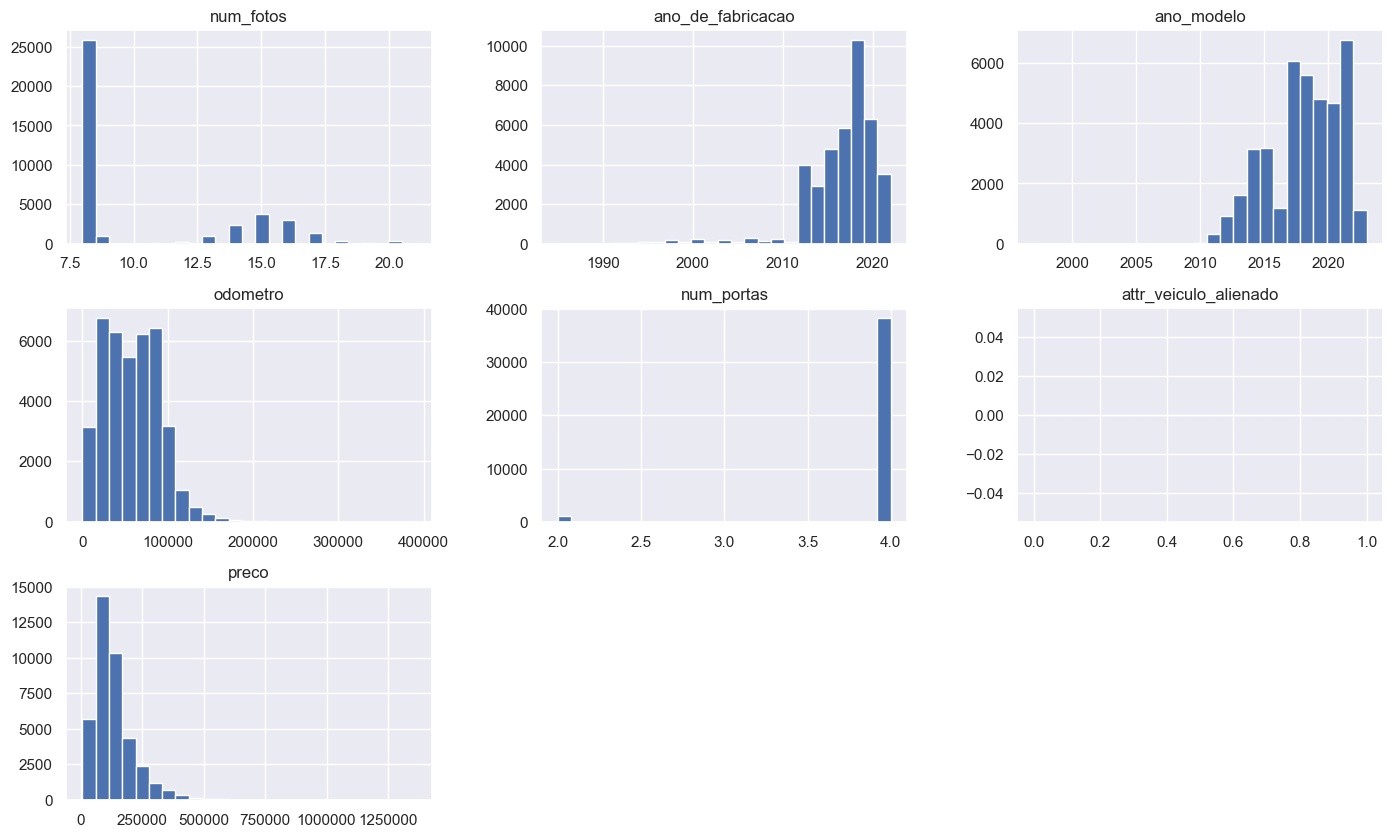

In [458]:
# num attributes
num_attributes.hist(bins=25); 

### 1.5.1.1. Numerical Atributes Correlation

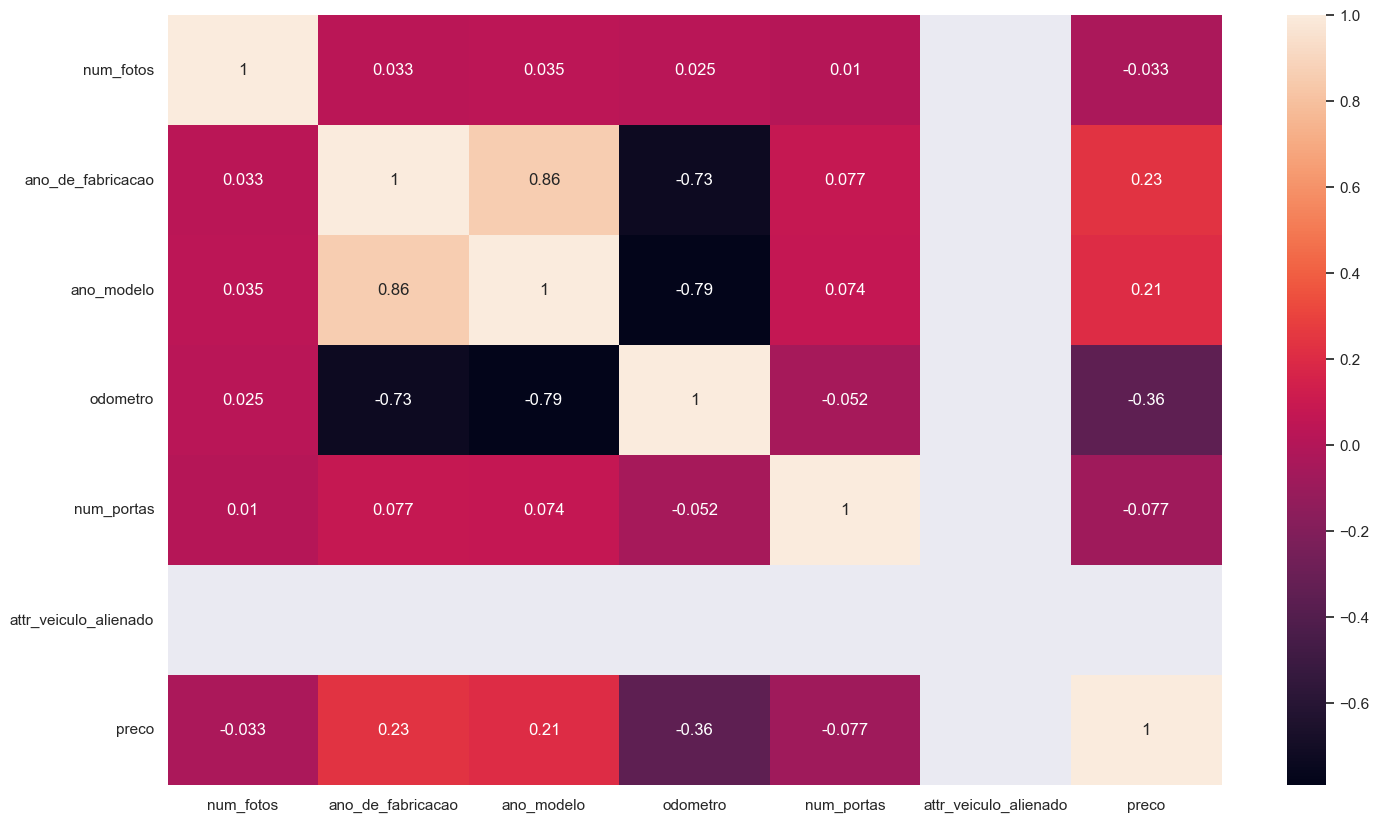

In [459]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True);

De acordo com as correlações, removemos:

num_fotos
att_veiculo_alienado
num_portas


### 1.5.2. Categorical Attributes

In [460]:
cat_attributes.head()

id       marca  modelo  \
0  105869496634249611881157692933406072990  VOLKSWAGEN  AMAROK   
1   14165644411757892901957277406025007093      JAGUAR  F-PACE   
2   78515656948521351316652580664682810356   CHEVROLET   CRUZE   
3   36797041166808090517929207429817328298     PORSCHE     718   
4  338618517701891995317200439137014723900       VOLVO    XC90   

                                              versao      cambio  \
0  2.0 TRENDLINE 4X4 CD 16V TURBO INTERCOOLER DIE...  Automática   
1    2.0 16V TURBO DIESEL PRESTIGE AWD 4P AUTOMÁTICO  Automática   
2                      1.8 LT 16V FLEX 4P AUTOMÁTICO  Automática   
3                    2.0 16V H4 GASOLINA BOXSTER PDK  Automática   
4   2.0 INSCRIPTION TURBO GASOLINA 4P 4X4 AUTOMÁTICO  Automática   

                   tipo blindado     cor tipo_vendedor cidade_vendedor  ...  \
0                Picape        N   Preto            PF       São Paulo  ...   
1  Utilitário esportivo        N  Branco            PF  Rio de Janeiro  ...   
2                  Sedã        N   Prata            PJ  Rio de Janeiro  ...   
3                Picape        N  Branco            PF       São Paulo  ...   
4  Utilitário esportivo        N   Preto            PF  Ribeirão Preto  ...   

  entrega_delivery  troca  elegivel_revisao  attr_veiculo_aceita_troca  \
0            False  False             False               Aceita troca   
1            False  False             False               Aceita troca   
2             True   True             False               Aceita troca   
3            False  False             False               Aceita troca   
4            False  False             False               Aceita troca   

   attr_veiculo_unico_dono  \
0                      NaN   
1                      NaN   
2                      NaN   
3                      NaN   
4                      NaN   

  attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria  \
0       Todas as revisões feitas pela concessionária          
1       Todas as revisões feitas pela concessionária          
2                                                NaN          
3       Todas as revisões feitas pela concessionária          
4       Todas as revisões feitas pela concessionária          

  attr_veiculo_ipva_pago attr_veiculo_licenciado  \
0              IPVA pago              Licenciado   
1              IPVA pago                     NaN   
2                    NaN                     NaN   
3                    NaN                     NaN   
4                    NaN                     NaN   

  attr_veiculo_garantia_de_fabrica  \
0                              NaN   
1                              NaN   
2                              NaN   
3                              NaN   
4                              NaN   

  attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro  
0      Todas as revisões feitas pela agenda do carro          
1      Todas as revisões feitas pela agenda do carro          
2                                                NaN          
3                                                NaN          
4      Todas as revisões feitas pela agenda do carro          

[5 rows x 22 columns]

In [461]:
# cat atributes
cat_attributes.apply( lambda x: x.unique().shape[0] )

id                                                            39446
marca                                                            41
modelo                                                          473
versao                                                         2058
cambio                                                            7
tipo                                                              8
blindado                                                          2
cor                                                               8
tipo_vendedor                                                     2
cidade_vendedor                                                 648
estado_vendedor                                                  25
tipo_anuncio                                                      4
entrega_delivery                                                  2
troca                                                             2
elegivel_revisao                                

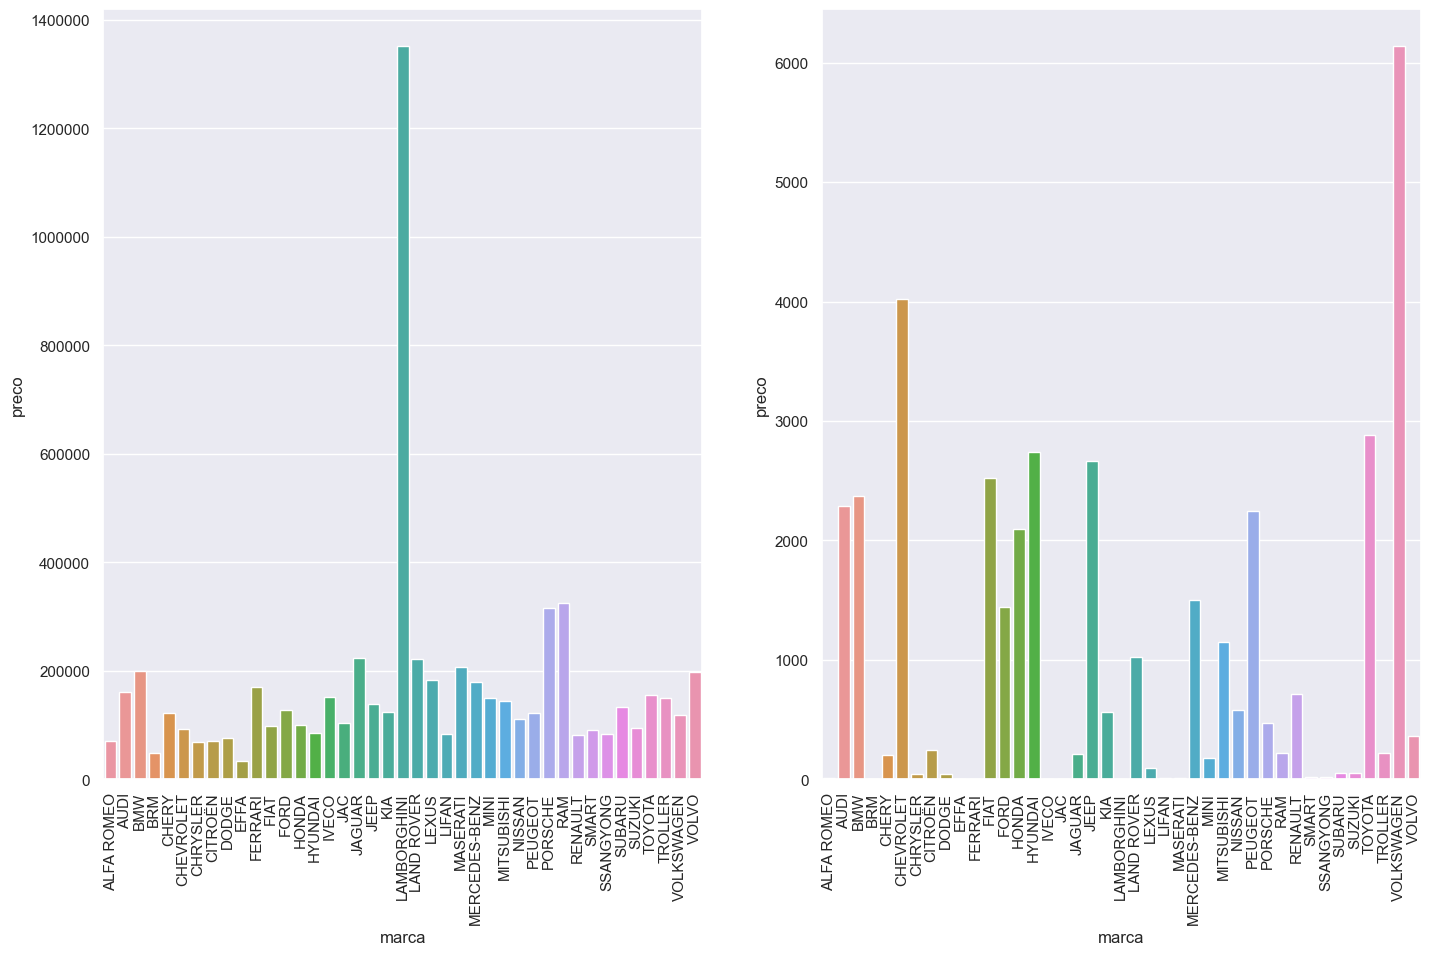

In [462]:
#marca mean ( REMOVER LAMBO para evitar Outliers ) FREQUENCY ENCODING
plt.subplot(1 ,2 ,1 )
aux00 = df1[['marca' , 'preco']].groupby('marca').mean().reset_index()
sns.barplot( x='marca', y='preco', data=aux00 );
plt.xticks( rotation=90 );
#marca count
plt.subplot(1 ,2 ,2 )
aux01 = df1[['marca' , 'preco']].groupby('marca').count().reset_index()
sns.barplot( x='marca', y='preco', data=aux01 );
plt.xticks( rotation=90 );

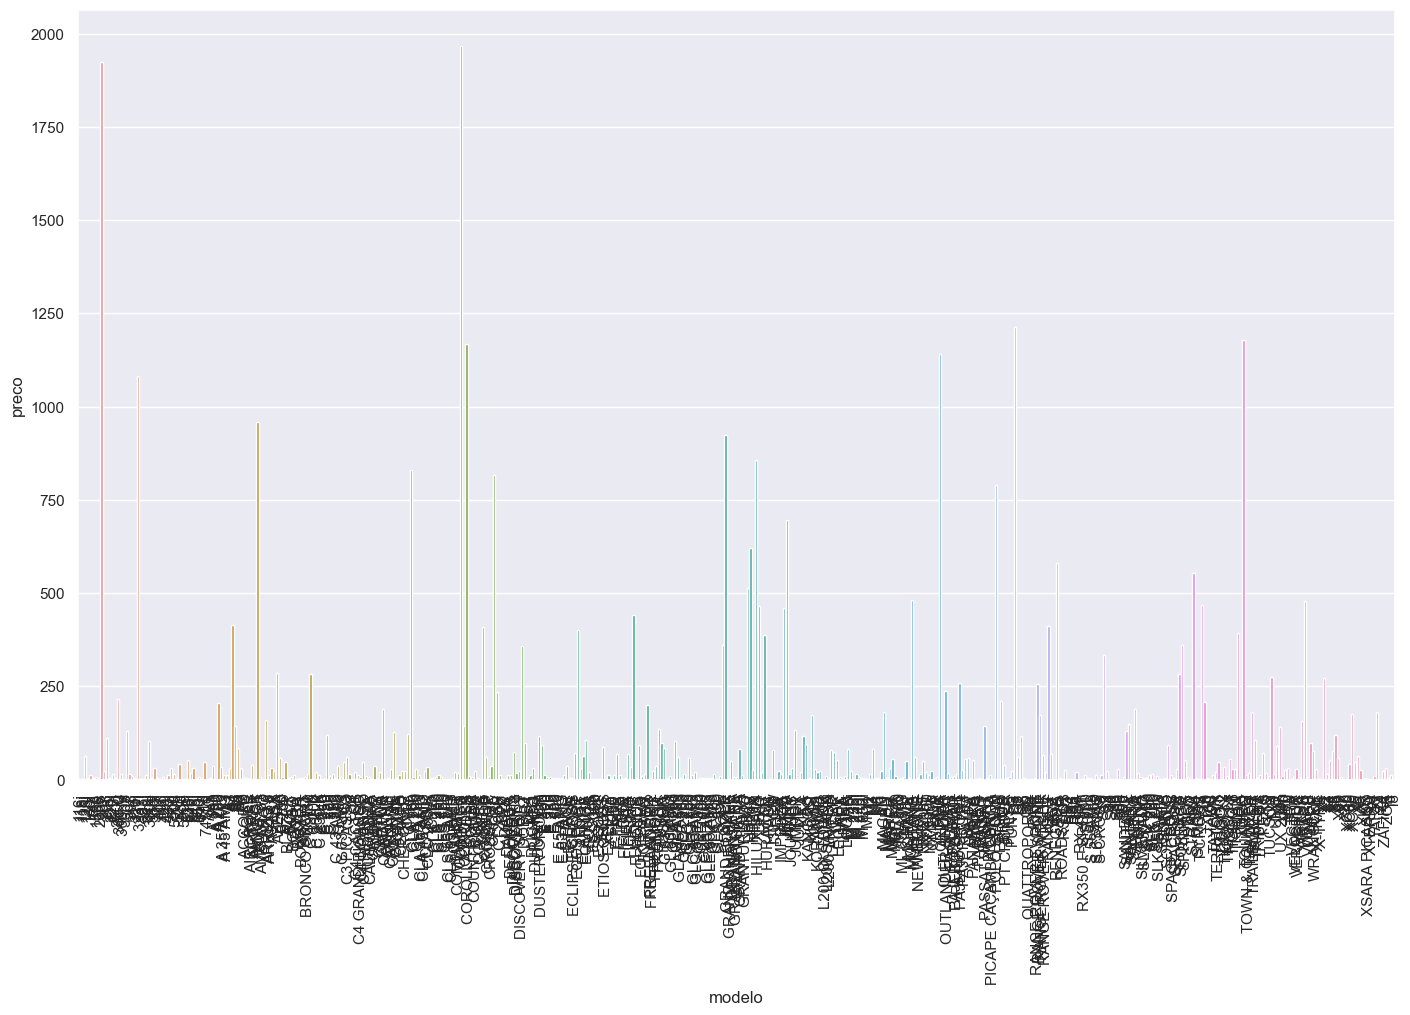

In [463]:
#modelo ( FREQUENCY ENCODING )
aux00 = df1[['modelo' , 'preco']].groupby('modelo').count().reset_index()
sns.barplot( x='modelo', y='preco', data=aux00 );
plt.xticks( rotation=90 );

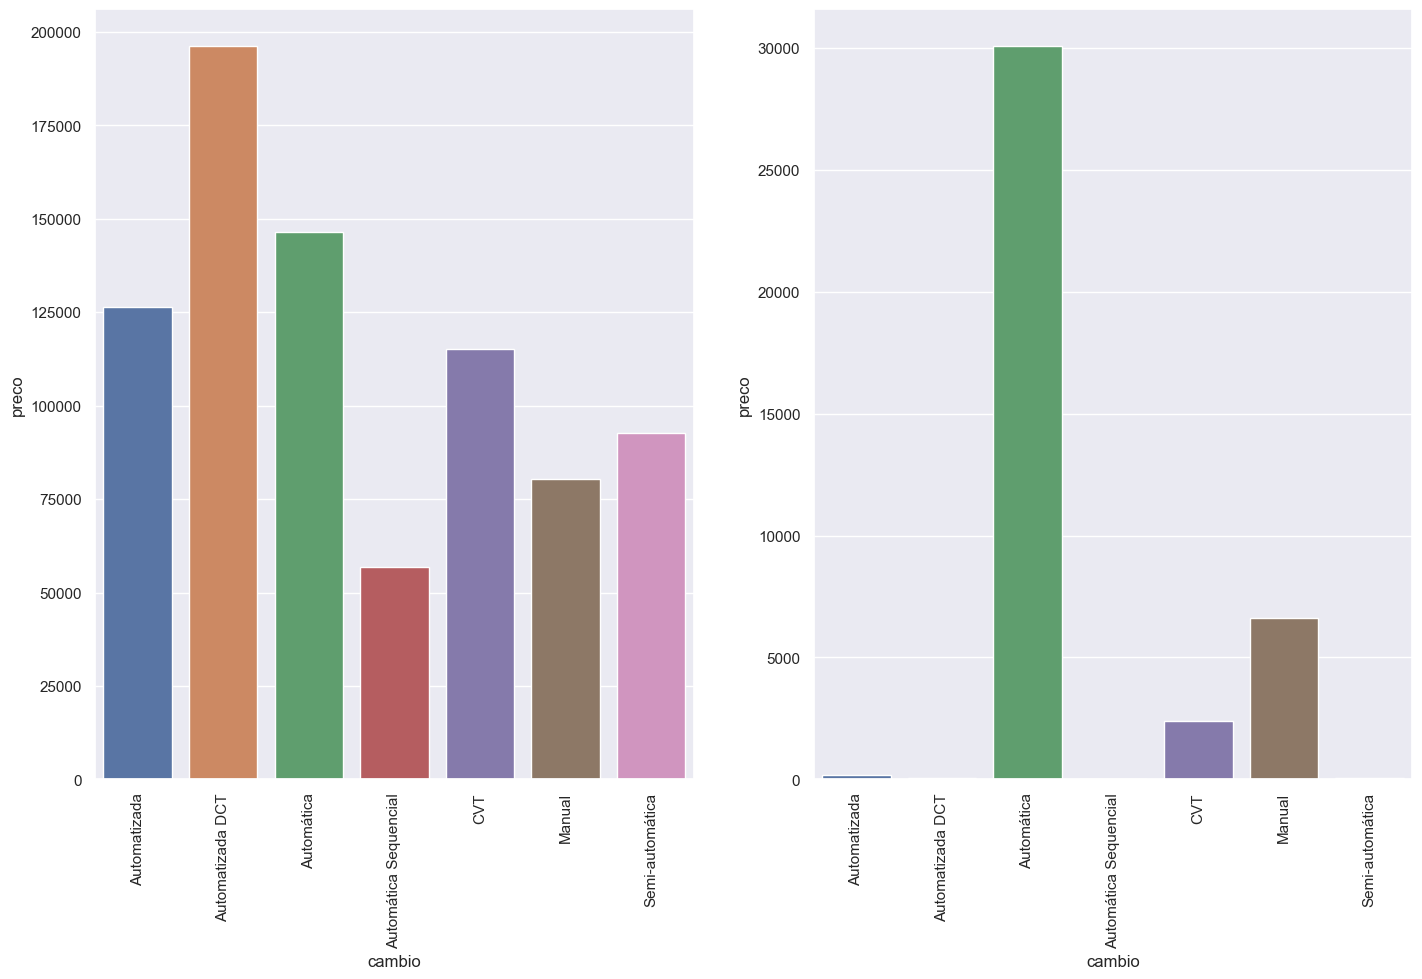

In [464]:
#cambio mean ( LABEL ENCODING )
plt.subplot(1 ,2 ,1 )
aux00 = df1[['cambio' , 'preco']].groupby('cambio').mean().reset_index()
sns.barplot( x='cambio', y='preco', data=aux00 );
plt.xticks( rotation=90 );
#cambio count
plt.subplot(1 ,2 ,2 )
aux01 = df1[['cambio' , 'preco']].groupby('cambio').count().reset_index()
sns.barplot( x='cambio', y='preco', data=aux01 );
plt.xticks( rotation=90 );

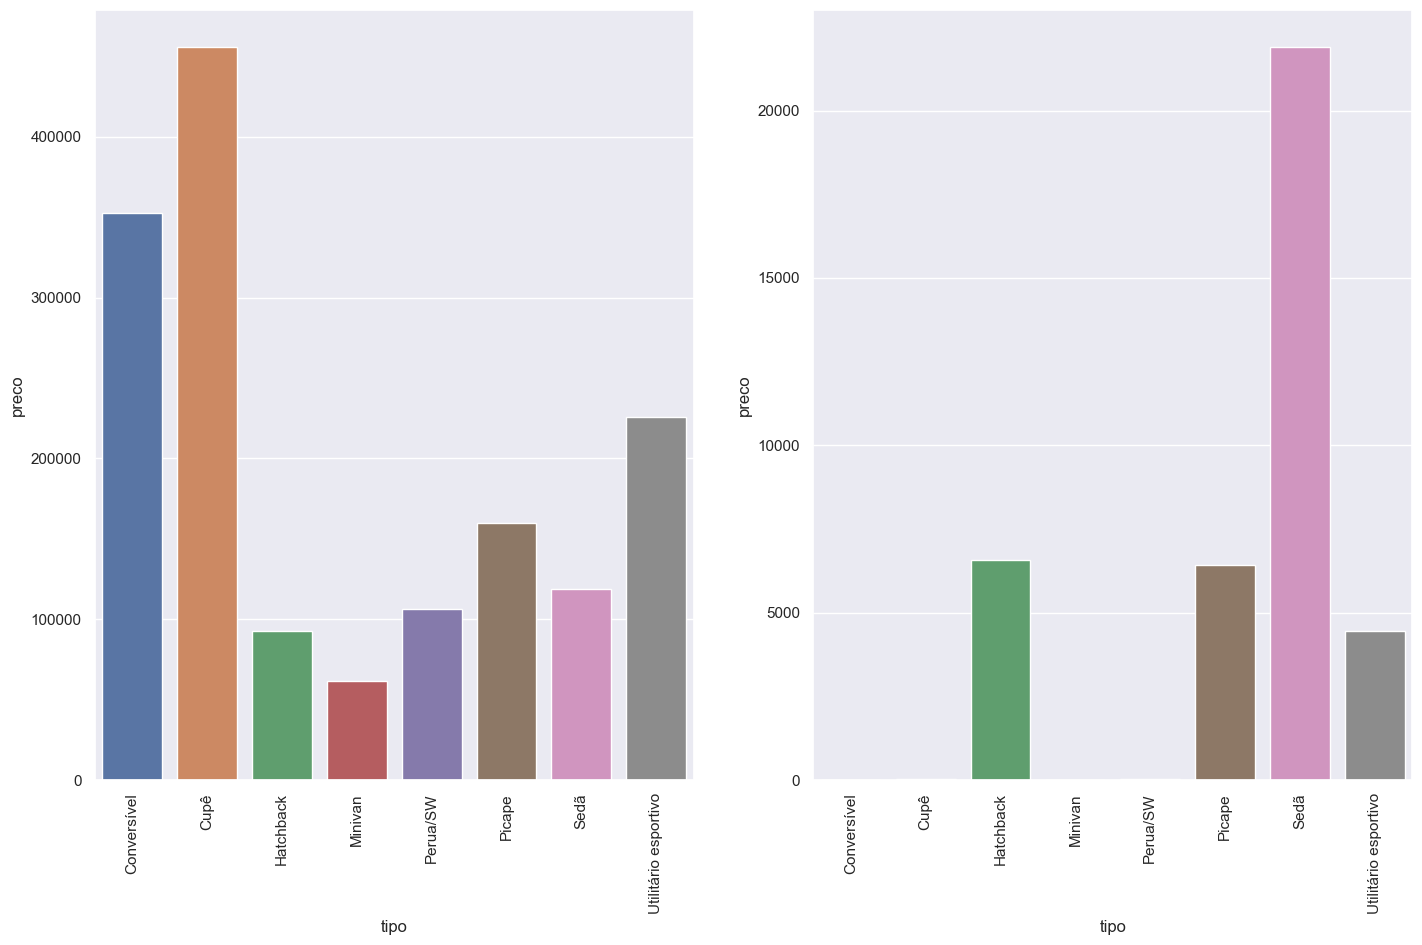

In [465]:
#tipo mean ( LABEL ENCODING )
plt.subplot(1 ,2 ,1 )
aux00 = df1[['tipo' , 'preco']].groupby('tipo').mean().reset_index()
sns.barplot( x='tipo', y='preco', data=aux00 );
plt.xticks( rotation=90 );
#tipo count
plt.subplot(1 ,2 ,2 )
aux01 = df1[['tipo' , 'preco']].groupby('tipo').count().reset_index()
sns.barplot( x='tipo', y='preco', data=aux01 );
plt.xticks( rotation=90 );

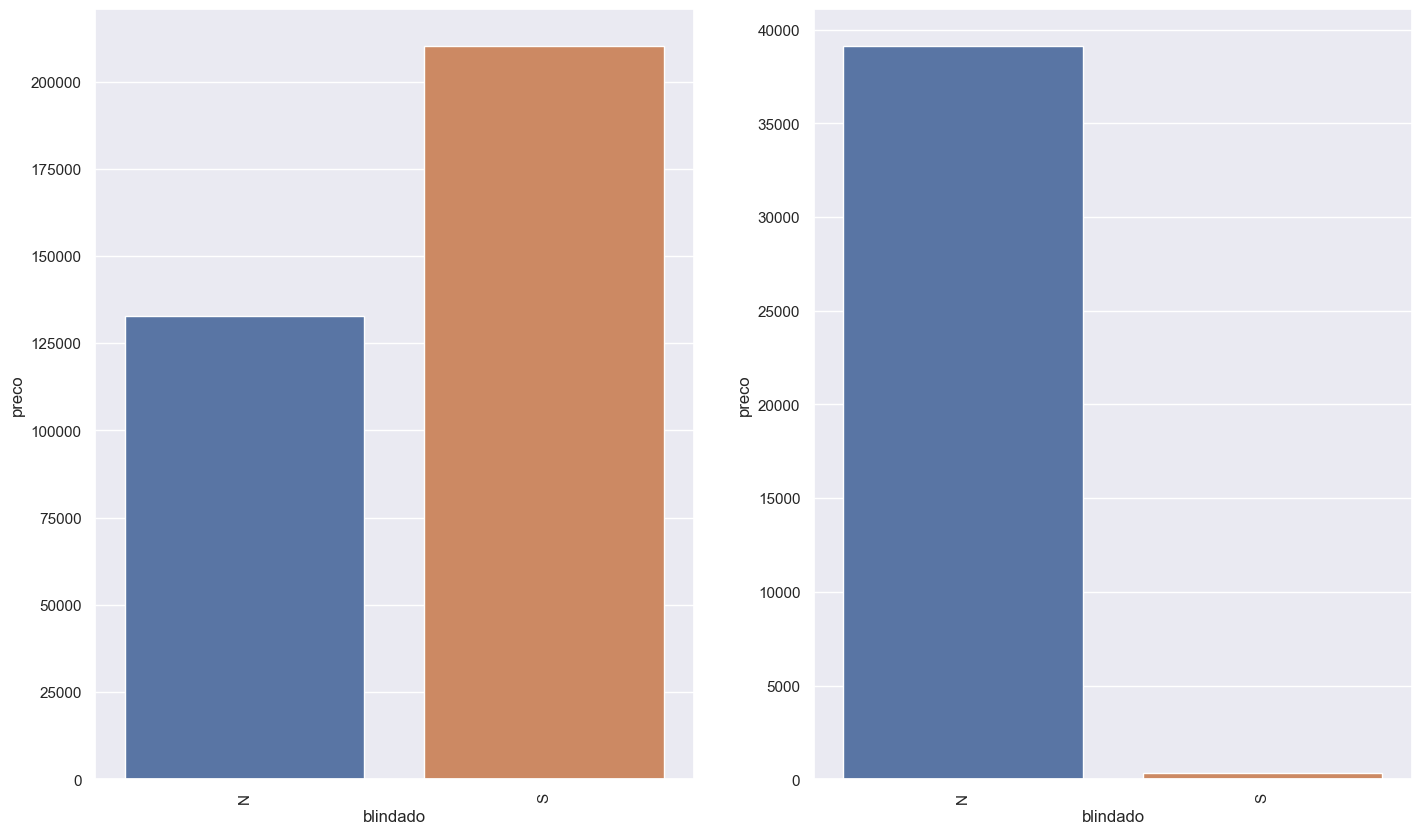

In [466]:
#blindado ( 0 or 1 ENCODING )
#blindado mean
plt.subplot(1 ,2 ,1 )
aux00 = df1[['blindado' , 'preco']].groupby('blindado').mean().reset_index()
sns.barplot( x='blindado', y='preco', data=aux00 );
plt.xticks( rotation=90 );
#blindado count
plt.subplot(1 ,2 ,2 )
aux01 = df1[['blindado' , 'preco']].groupby('blindado').count().reset_index()
sns.barplot( x='blindado', y='preco', data=aux01 );
plt.xticks( rotation=90 );

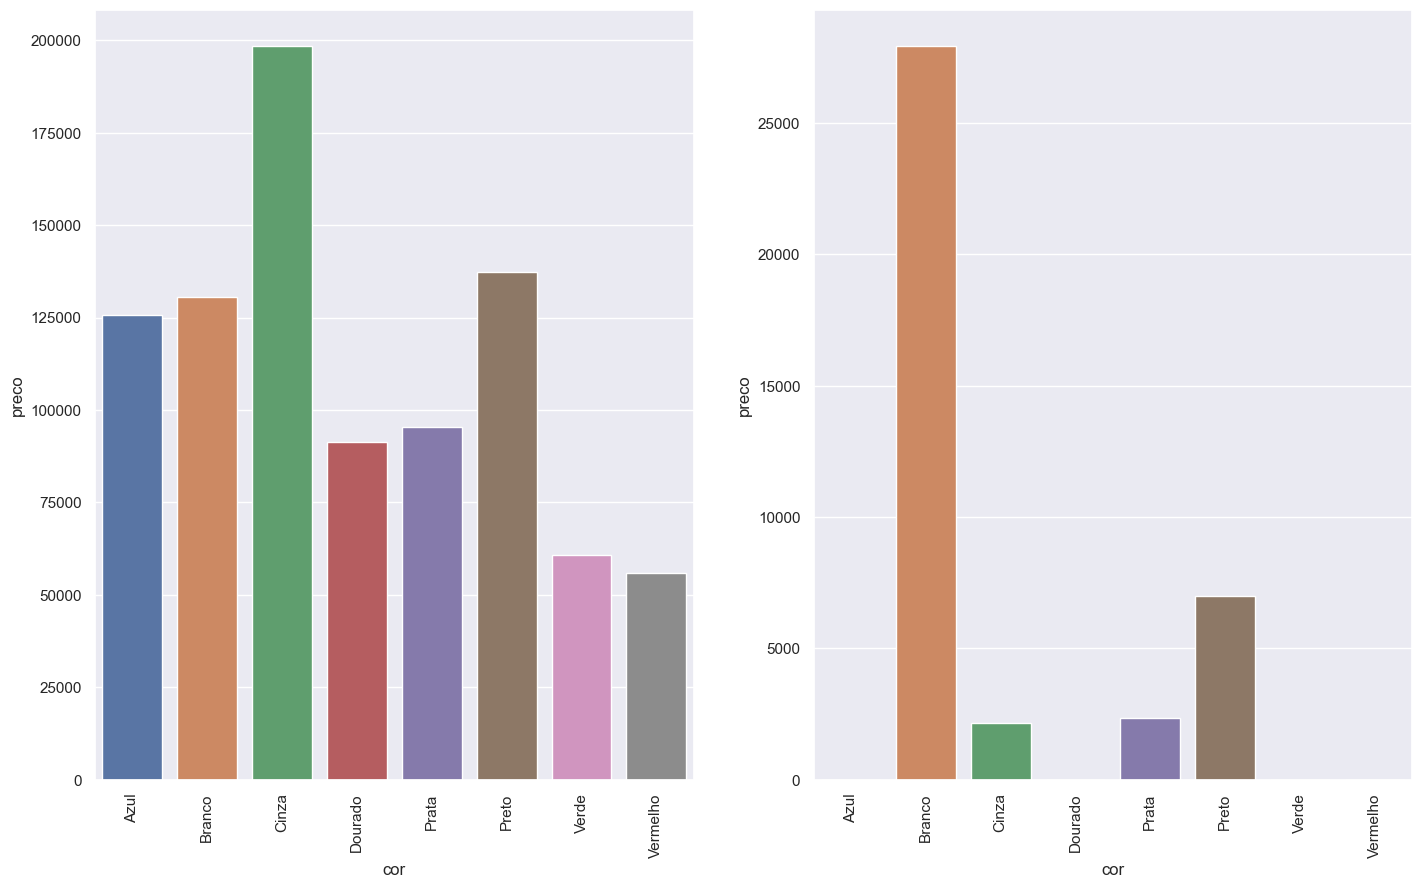

In [467]:
#cor ( LABEL/FREQUENCY ENCODING )
#cor mean
plt.subplot(1 ,2 ,1 )
aux00 = df1[['cor' , 'preco']].groupby('cor').mean().reset_index()
sns.barplot( x='cor', y='preco', data=aux00 );
plt.xticks( rotation=90 );
#cor count
plt.subplot(1 ,2 ,2 )
aux01 = df1[['cor' , 'preco']].groupby('cor').count().reset_index()
sns.barplot( x='cor', y='preco', data=aux01 );
plt.xticks( rotation=90 );

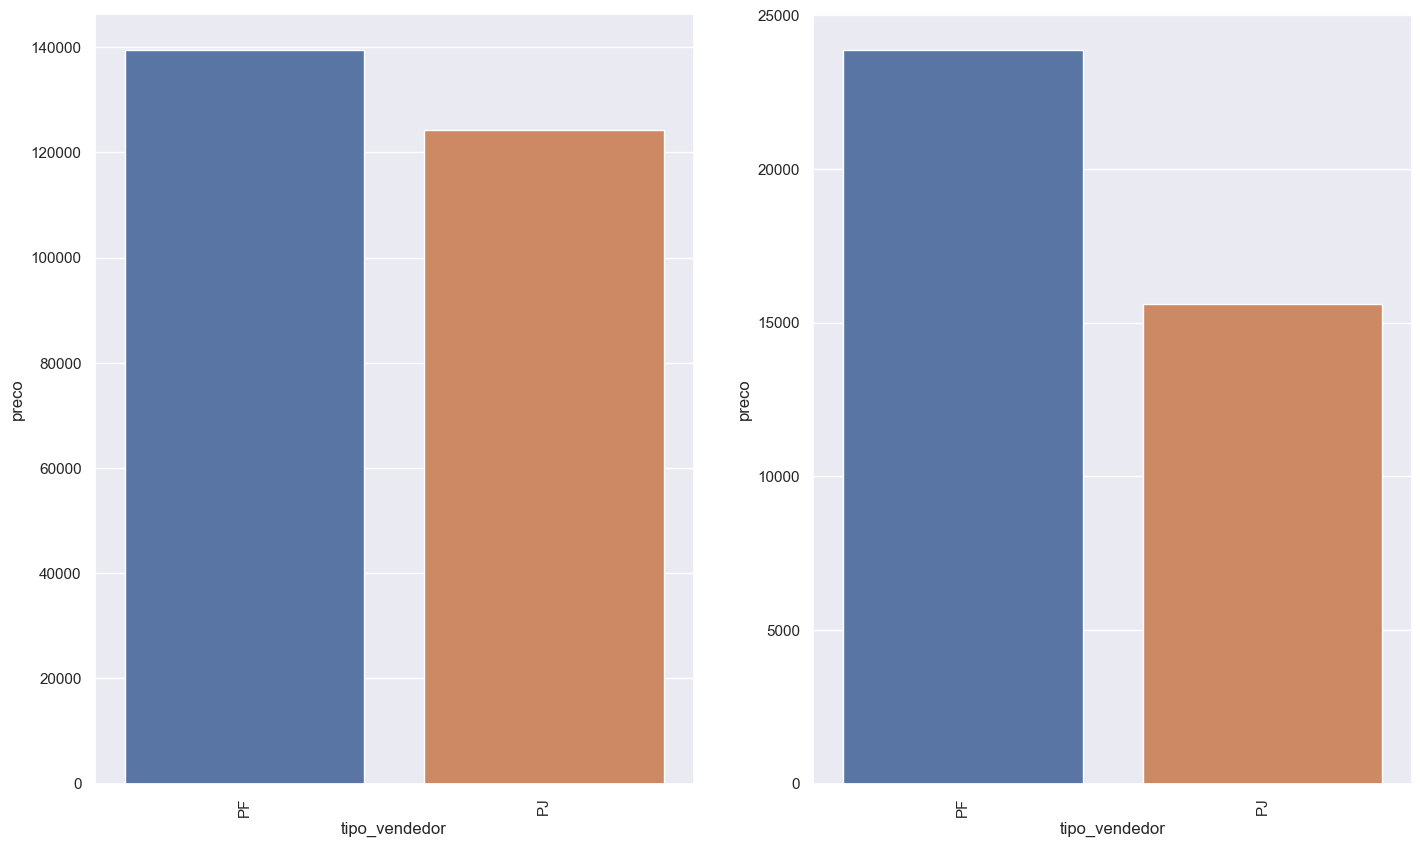

In [468]:
#tipo_vendedor ( Alta correlação com TIPO ANUNCIO, escolhemos seguir com TIPO ANUNCIO )
plt.subplot(1 ,2 ,1 )
aux00 = df1[['tipo_vendedor' , 'preco']].groupby('tipo_vendedor').mean().reset_index()
sns.barplot( x='tipo_vendedor', y='preco', data=aux00 );
plt.xticks( rotation=90 );
#tipo_vendedor count
plt.subplot(1 ,2 ,2 )
aux01 = df1[['tipo_vendedor' , 'preco']].groupby('tipo_vendedor').count().reset_index()
sns.barplot( x='tipo_vendedor', y='preco', data=aux01 );
plt.xticks( rotation=90 );

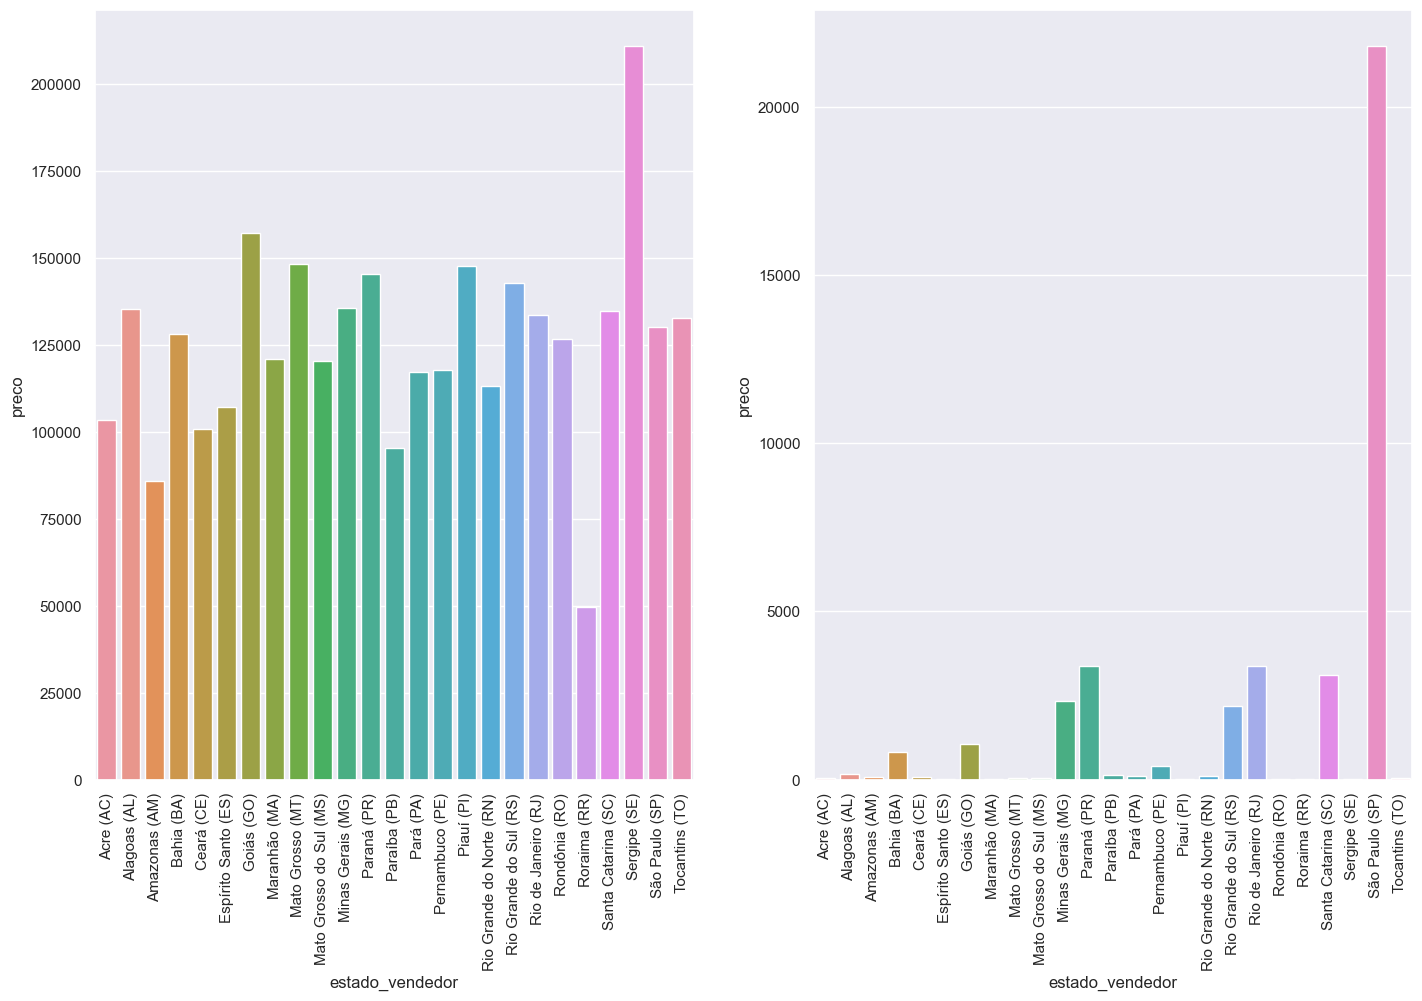

In [469]:
#estado_vendedor mean ( OUT )
plt.subplot(1 ,2 ,1 )
aux00 = df1[['estado_vendedor' , 'preco']].groupby('estado_vendedor').mean().reset_index()
sns.barplot( x='estado_vendedor', y='preco', data=aux00 );
plt.xticks( rotation=90 );
#estado_vendedor count
plt.subplot(1 ,2 ,2 )
aux01 = df1[['estado_vendedor' , 'preco']].groupby('estado_vendedor').count().reset_index()
sns.barplot( x='estado_vendedor', y='preco', data=aux01 );
plt.xticks( rotation=90 );

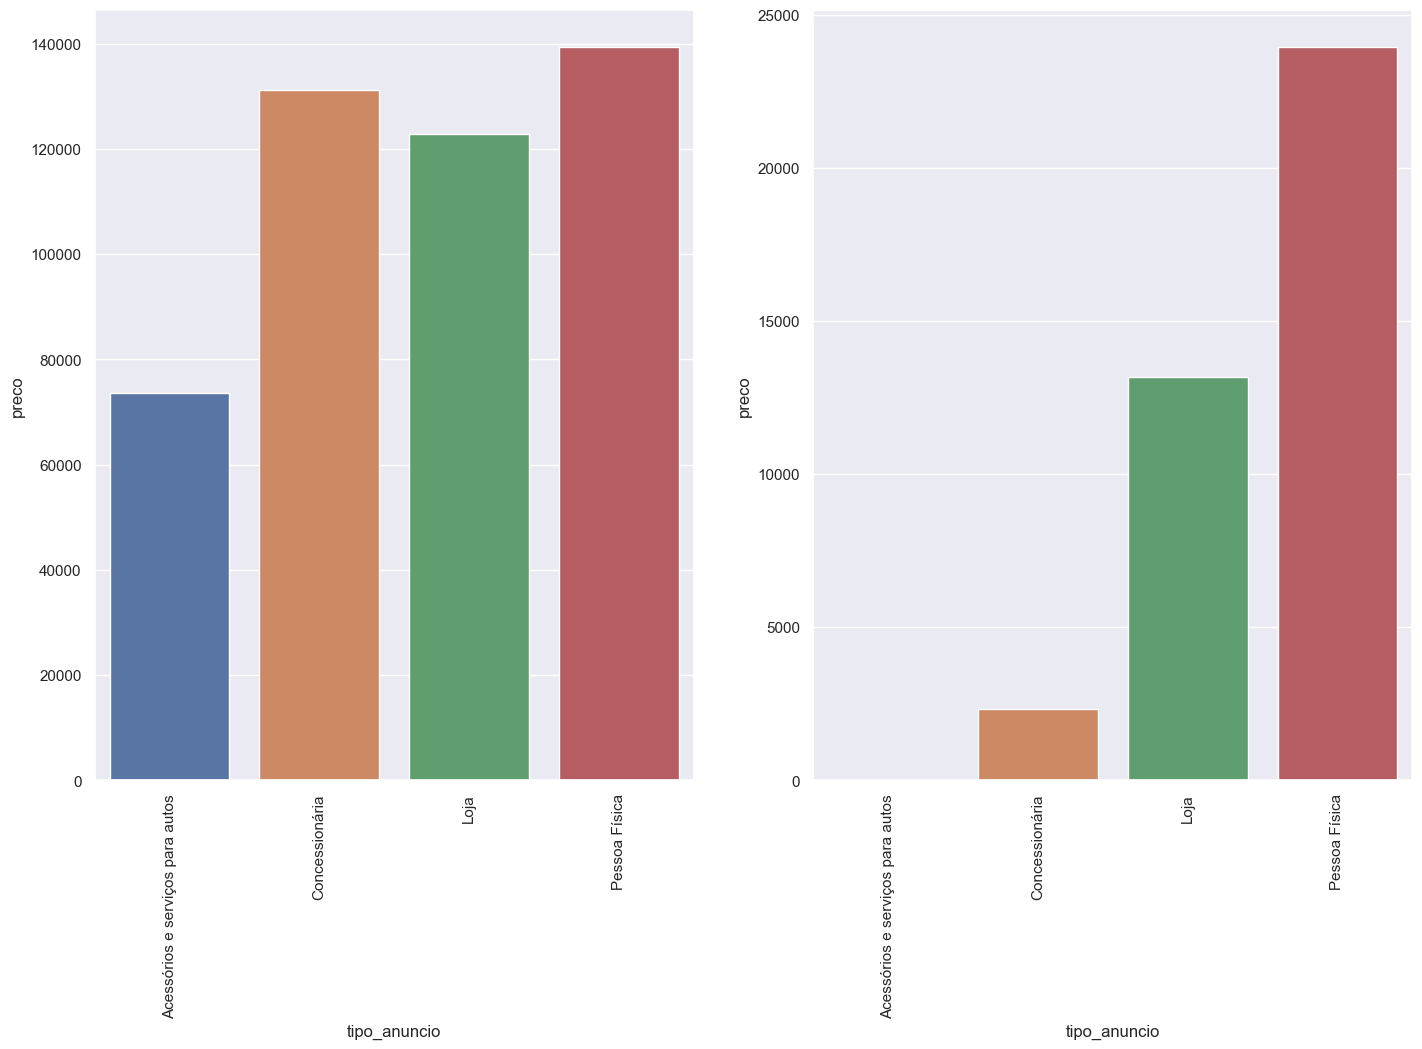

In [470]:
#tipo_anuncio mean ( LABEL ENCODING )
plt.subplot(1 ,2 ,1 )
aux00 = df1[['tipo_anuncio' , 'preco']].groupby('tipo_anuncio').mean().reset_index()
sns.barplot( x='tipo_anuncio', y='preco', data=aux00 );
plt.xticks( rotation=90 );
#tipo_anuncio count
plt.subplot(1 ,2 ,2 )
aux01 = df1[['tipo_anuncio' , 'preco']].groupby('tipo_anuncio').count().reset_index()
sns.barplot( x='tipo_anuncio', y='preco', data=aux01 );
plt.xticks( rotation=90 );

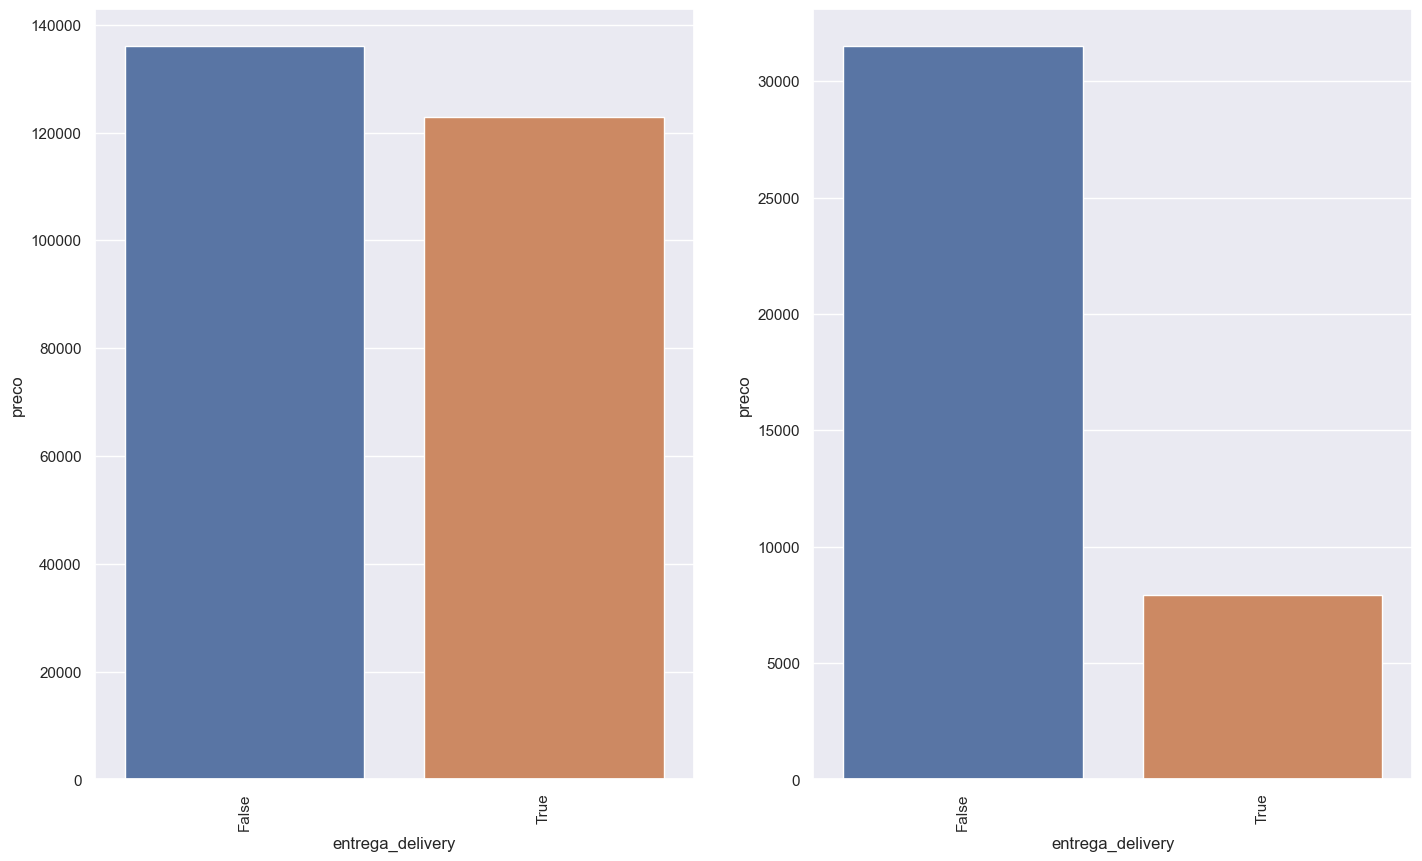

In [471]:
# entrega_delivery sum ( 0 or  1 )
plt.subplot(1 ,2 ,1 )
aux00 = df1[['entrega_delivery' , 'preco']].groupby('entrega_delivery').mean().reset_index()
sns.barplot( x='entrega_delivery', y='preco', data=aux00 );
plt.xticks( rotation=90 );
#entrega_delivery count
plt.subplot(1 ,2 ,2 )
aux01 = df1[['entrega_delivery' , 'preco']].groupby('entrega_delivery').count().reset_index()
sns.barplot( x='entrega_delivery', y='preco', data=aux01 );
plt.xticks( rotation=90 );

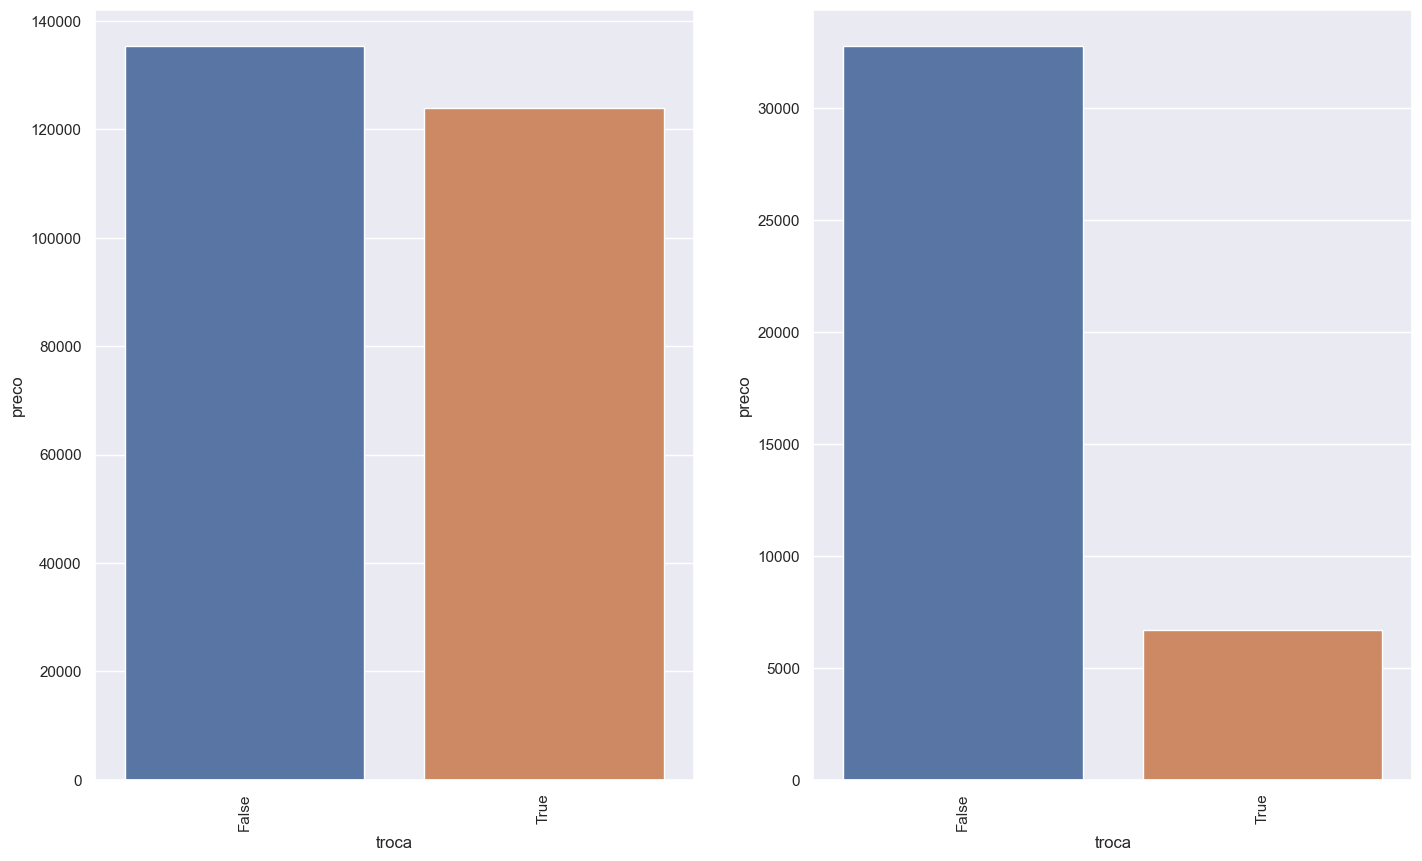

In [472]:
# troca ( 0 or 1 )
plt.subplot(1 ,2 ,1 )
aux00 = df1[['troca' , 'preco']].groupby('troca').mean().reset_index()
sns.barplot( x='troca', y='preco', data=aux00 );
plt.xticks( rotation=90 );
#troca count
plt.subplot(1 ,2 ,2 )
aux01 = df1[['troca' , 'preco']].groupby('troca').count().reset_index()
sns.barplot( x='troca', y='preco', data=aux01 );
plt.xticks( rotation=90 );

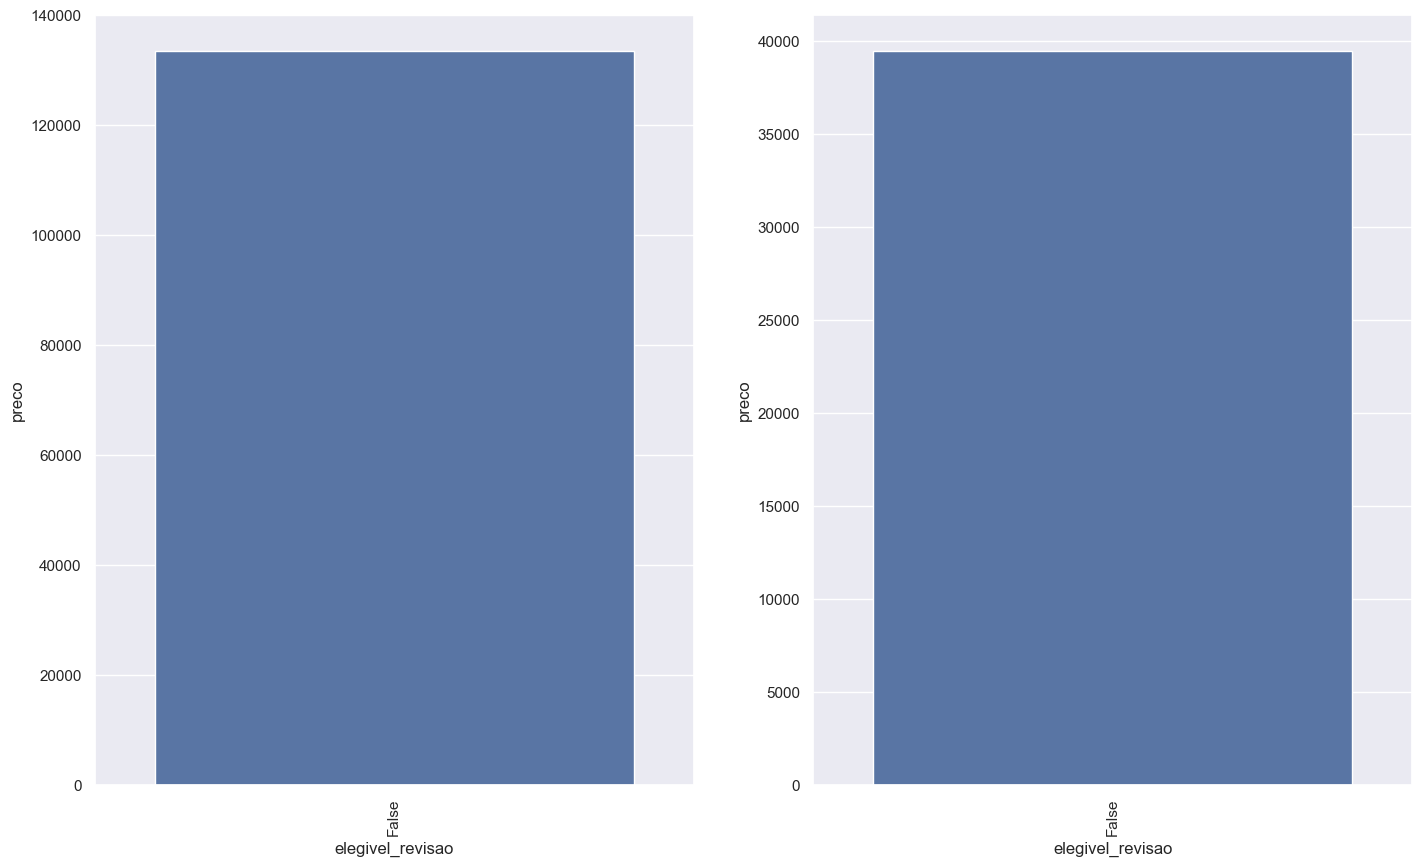

In [473]:
# elegivel_revisao ( OUT )
plt.subplot(1 ,2 ,1 )
aux00 = df1[['elegivel_revisao' , 'preco']].groupby('elegivel_revisao').mean().reset_index()
sns.barplot( x='elegivel_revisao', y='preco', data=aux00 );
plt.xticks( rotation=90 );
#elegivel_revisao count
plt.subplot(1 ,2 ,2 )
aux01 = df1[['elegivel_revisao' , 'preco']].groupby('elegivel_revisao').count().reset_index()
sns.barplot( x='elegivel_revisao', y='preco', data=aux01 );
plt.xticks( rotation=90 ); 

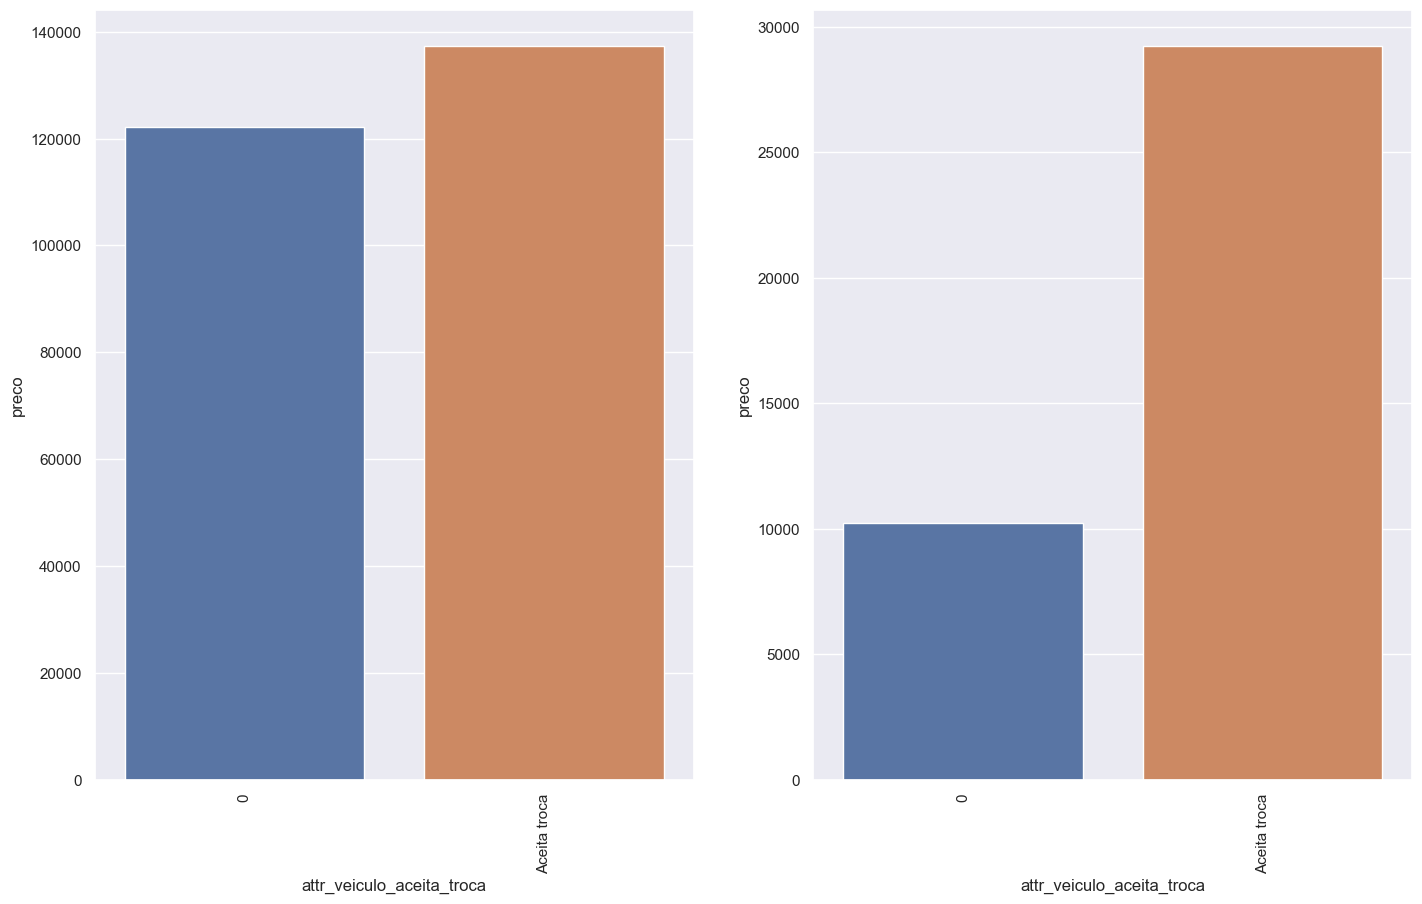

In [474]:
# attr_veiculo_aceita_troca ( or 0 1 )
df1['attr_veiculo_aceita_troca'] = df1['attr_veiculo_aceita_troca'].fillna(0) # preenche as linhas vazias
# attr_veiculo_aceita_troca sum
plt.subplot(1 ,2 ,1 )
aux00 = df1[['attr_veiculo_aceita_troca' , 'preco']].groupby('attr_veiculo_aceita_troca').mean().reset_index()
sns.barplot( x='attr_veiculo_aceita_troca', y='preco', data=aux00 );
plt.xticks( rotation=90 );
#attr_veiculo_aceita_troca count
plt.subplot(1 ,2 ,2 )
aux01 = df1[['attr_veiculo_aceita_troca' , 'preco']].groupby('attr_veiculo_aceita_troca').count().reset_index()
sns.barplot( x='attr_veiculo_aceita_troca', y='preco', data=aux01 );
plt.xticks( rotation=90 );

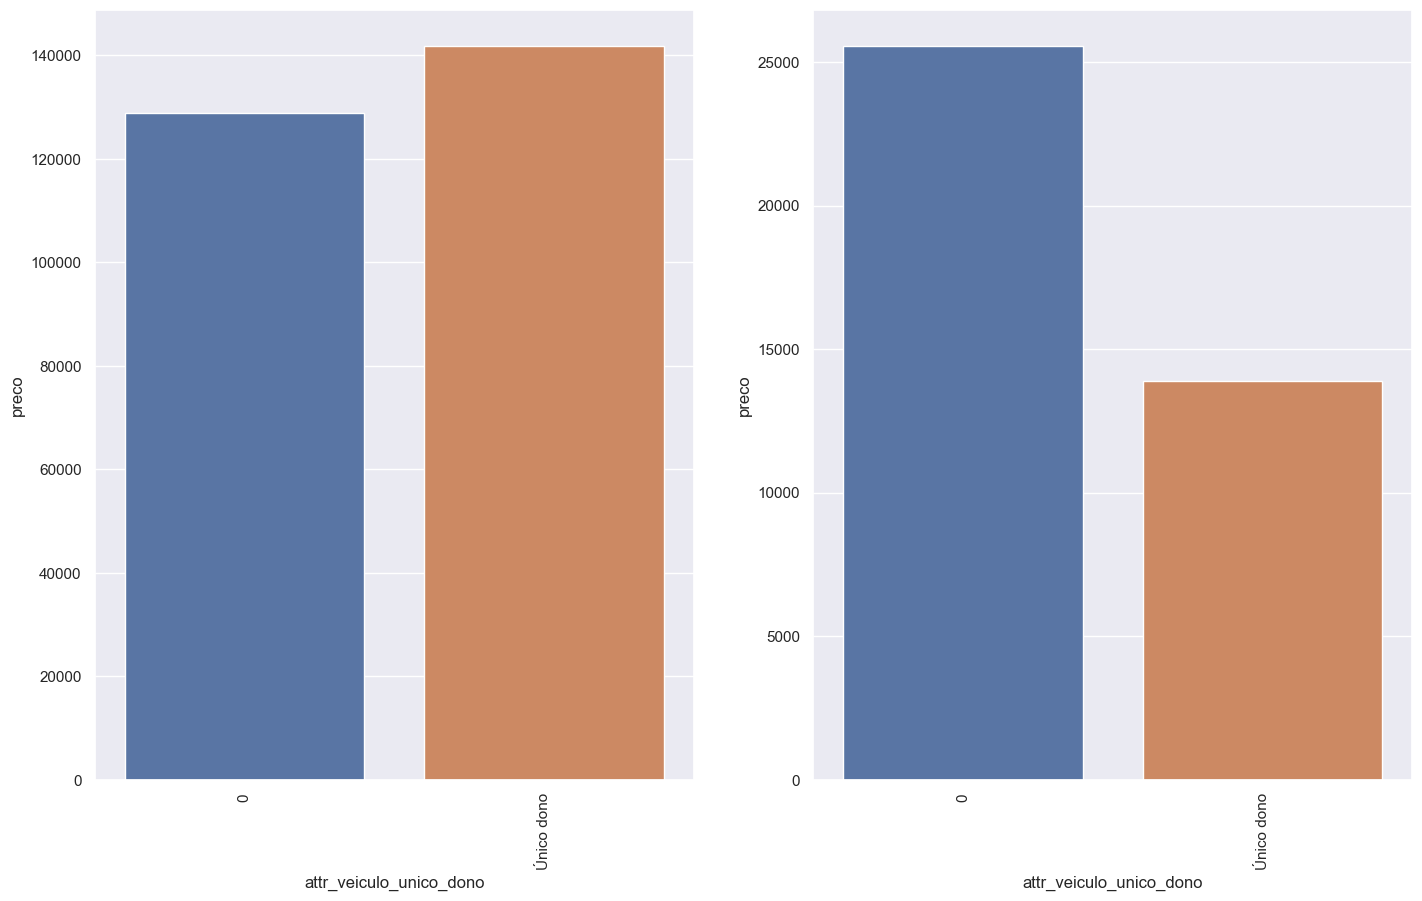

In [475]:
# attr_veiculo_unico_dono (  0 or 1 )
df1['attr_veiculo_unico_dono'] = df1['attr_veiculo_unico_dono'].fillna(0) # preenche as linhas vazias

# attr_veiculo_unico_dono sum
plt.subplot(1 ,2 ,1 )
aux00 = df1[['attr_veiculo_unico_dono' , 'preco']].groupby('attr_veiculo_unico_dono').mean().reset_index()
sns.barplot( x='attr_veiculo_unico_dono', y='preco', data=aux00 );
plt.xticks( rotation=90 );

#attr_veiculo_unico_dono count
plt.subplot(1 ,2 ,2 )
aux01 = df1[['attr_veiculo_unico_dono' , 'preco']].groupby('attr_veiculo_unico_dono').count().reset_index()
sns.barplot( x='attr_veiculo_unico_dono', y='preco', data=aux01 );
plt.xticks( rotation=90 );

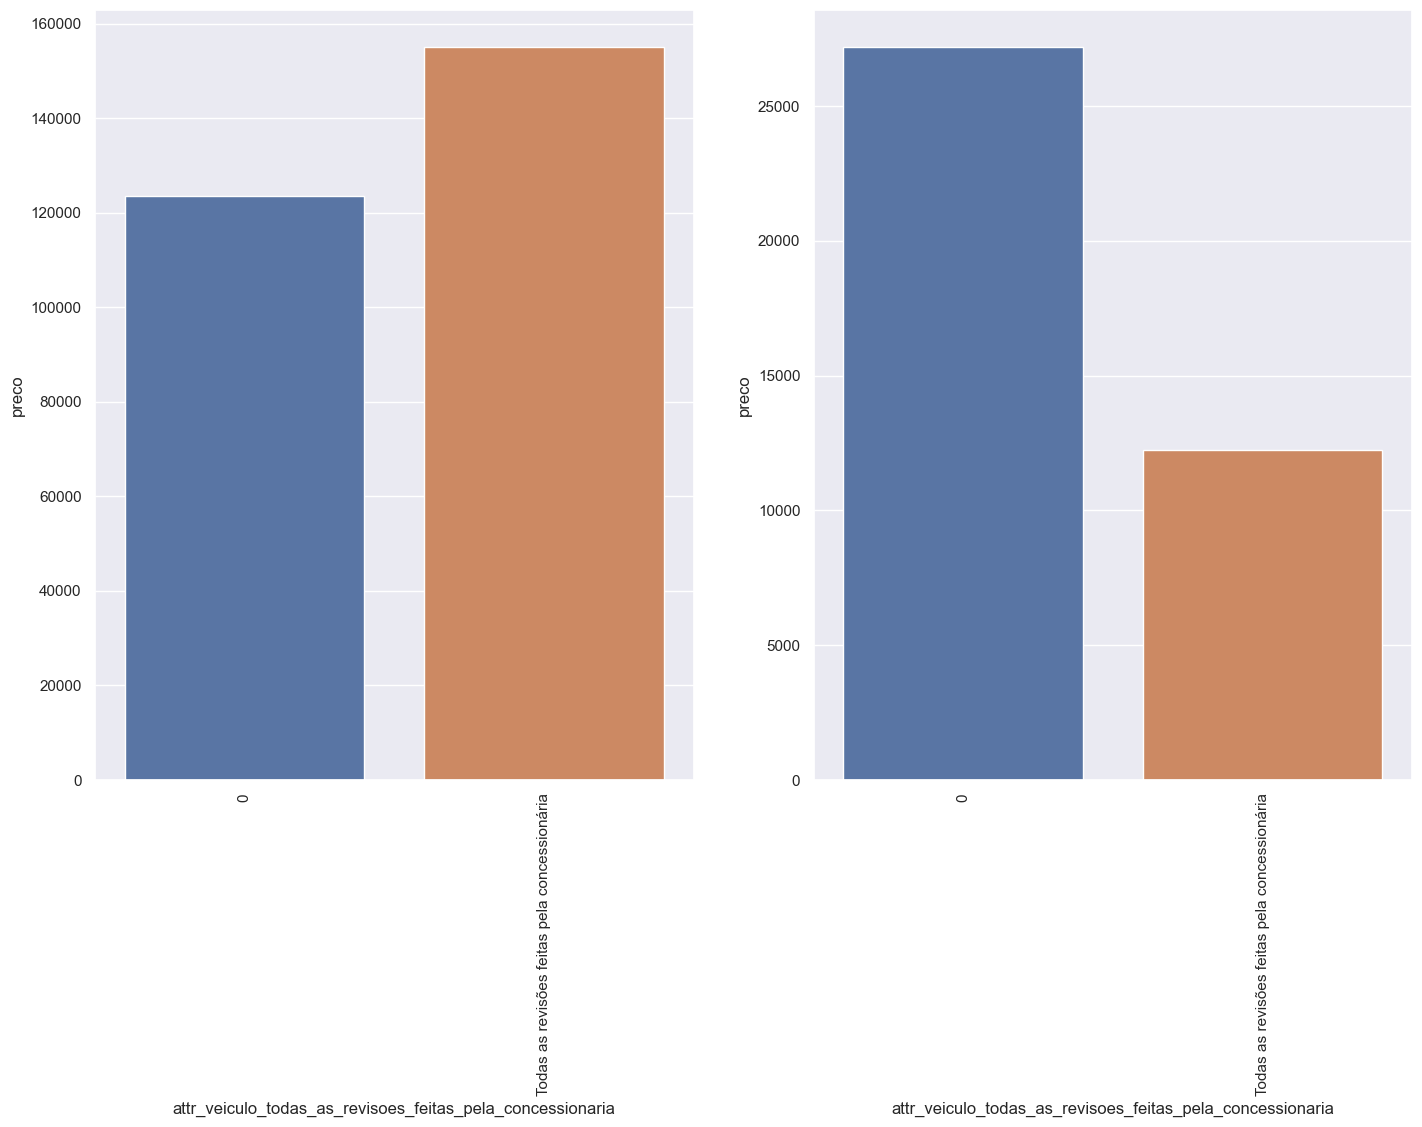

In [476]:
# attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria   ( 0 or 1 )
 
# attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria 
df1['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria'] = df1['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria'].fillna(0) # preenche as linhas vazias

# attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria sum
plt.subplot(1 ,2 ,1 )
aux00 = df1[['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria' , 'preco']].groupby('attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria').mean().reset_index()
sns.barplot( x='attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria', y='preco', data=aux00 );
plt.xticks( rotation=90 );

#attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria count
plt.subplot(1 ,2 ,2 )
aux01 = df1[['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria' , 'preco']].groupby('attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria').count().reset_index()
sns.barplot( x='attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria', y='preco', data=aux01 );
plt.xticks( rotation=90 );

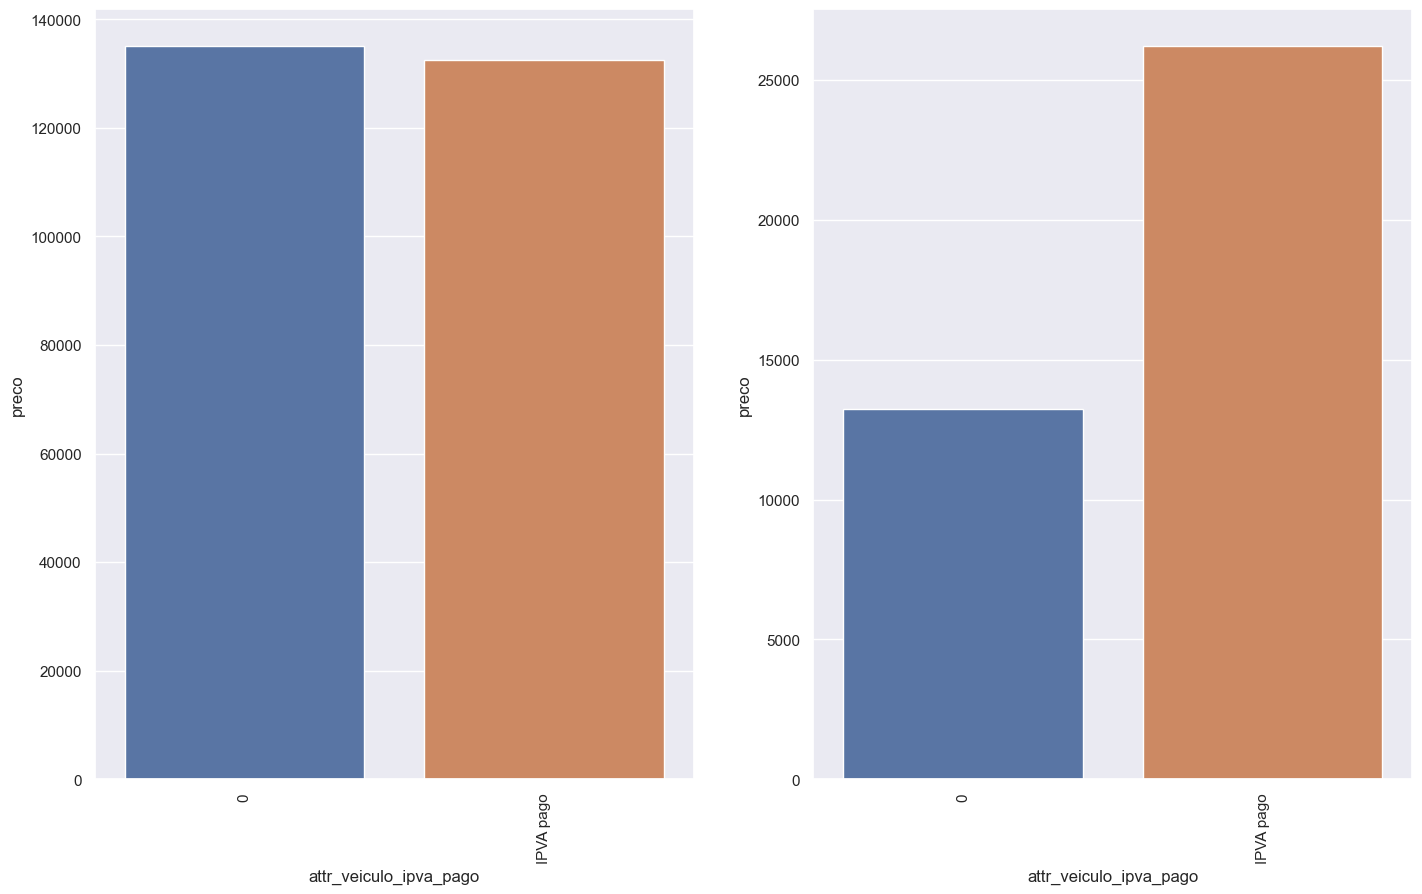

In [477]:
# attr_veiculo_ipva_pago ( OUT )
df1['attr_veiculo_ipva_pago'] = df1['attr_veiculo_ipva_pago'].fillna(0) # preenche as linhas vazias

# attr_veiculo_ipva_pago sum
plt.subplot(1 ,2 ,1 )
aux00 = df1[['attr_veiculo_ipva_pago' , 'preco']].groupby('attr_veiculo_ipva_pago').mean().reset_index()
sns.barplot( x='attr_veiculo_ipva_pago', y='preco', data=aux00 );
plt.xticks( rotation=90 );

#attr_veiculo_ipva_pago count
plt.subplot(1 ,2 ,2 )
aux01 = df1[['attr_veiculo_ipva_pago' , 'preco']].groupby('attr_veiculo_ipva_pago').count().reset_index()
sns.barplot( x='attr_veiculo_ipva_pago', y='preco', data=aux01 );
plt.xticks( rotation=90 );

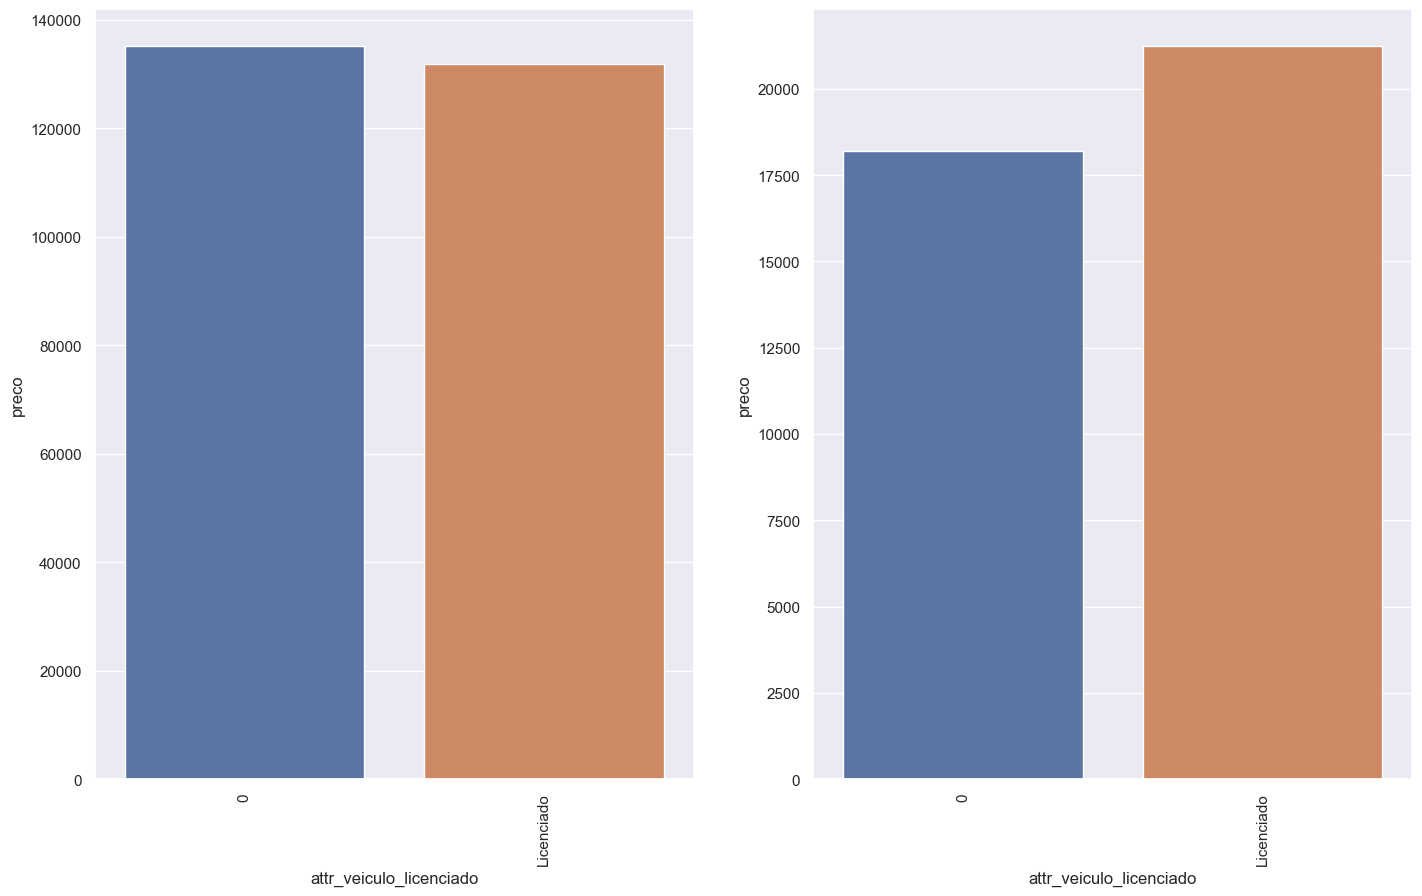

In [478]:
# attr_veiculo_licenciado ( OUT )
df1['attr_veiculo_licenciado'] = df1['attr_veiculo_licenciado'].fillna(0) # preenche as linhas vazias

# attr_veiculo_licenciado sum
plt.subplot(1 ,2 ,1 )
aux00 = df1[['attr_veiculo_licenciado' , 'preco']].groupby('attr_veiculo_licenciado').mean().reset_index()
sns.barplot( x='attr_veiculo_licenciado', y='preco', data=aux00 );
plt.xticks( rotation=90 );

#attr_veiculo_licenciado count
plt.subplot(1 ,2 ,2 )
aux01 = df1[['attr_veiculo_licenciado' , 'preco']].groupby('attr_veiculo_licenciado').count().reset_index()
sns.barplot( x='attr_veiculo_licenciado', y='preco', data=aux01 );
plt.xticks( rotation=90 ); 


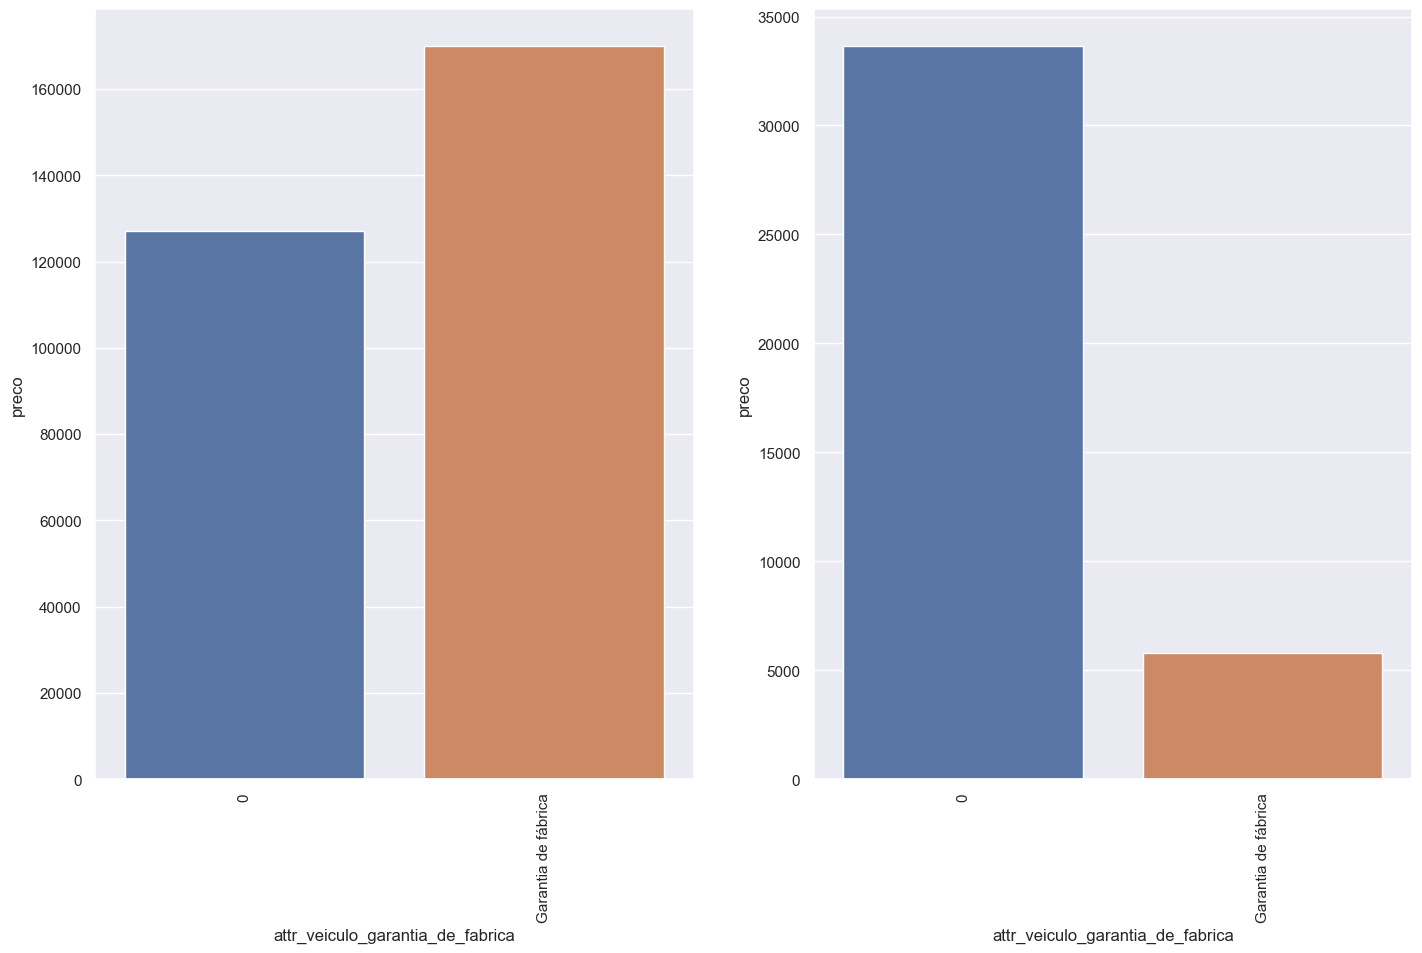

In [479]:
# attr_veiculo_garantia_de_fabrica ( 0 or 1 )
df1['attr_veiculo_garantia_de_fabrica'] = df1['attr_veiculo_garantia_de_fabrica'].fillna(0) # preenche as linhas vazias

# attr_veiculo_garantia_de_fabrica sum
plt.subplot(1 ,2 ,1 )
aux00 = df1[['attr_veiculo_garantia_de_fabrica' , 'preco']].groupby('attr_veiculo_garantia_de_fabrica').mean().reset_index()
sns.barplot( x='attr_veiculo_garantia_de_fabrica', y='preco', data=aux00 );
plt.xticks( rotation=90 );

#attr_veiculo_garantia_de_fabrica count
plt.subplot(1 ,2 ,2 )
aux01 = df1[['attr_veiculo_garantia_de_fabrica' , 'preco']].groupby('attr_veiculo_garantia_de_fabrica').count().reset_index()
sns.barplot( x='attr_veiculo_garantia_de_fabrica', y='preco', data=aux01 );
plt.xticks( rotation=90 ); 

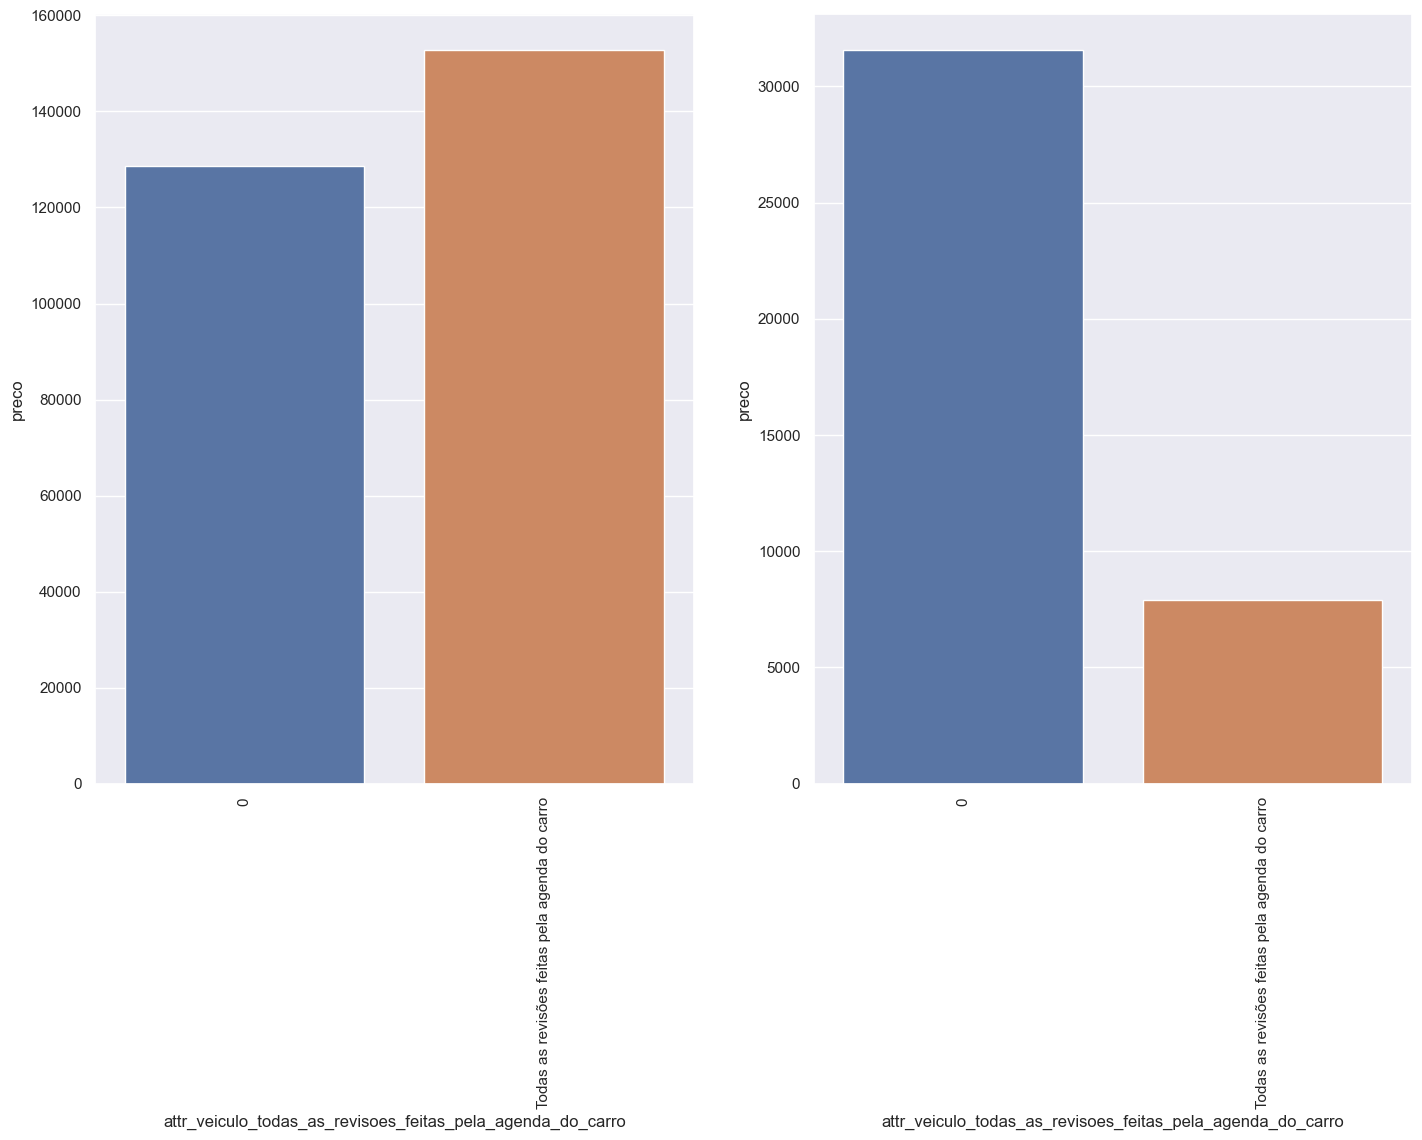

In [480]:
# attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro ( OUT correlacao alta com revisao concessionaria )
df1['attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro'] = df1['attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro'].fillna(0) # preenche as linhas vazias

# attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro sum
plt.subplot(1 ,2 ,1 )
aux00 = df1[['attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro' , 'preco']].groupby('attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro').mean().reset_index()
sns.barplot( x='attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro', y='preco', data=aux00 );
plt.xticks( rotation=90 );

#attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro count
plt.subplot(1 ,2 ,2 )
aux01 = df1[['attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro' , 'preco']].groupby('attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro').count().reset_index()
sns.barplot( x='attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro', y='preco', data=aux01 );
plt.xticks( rotation=90 ); 

### 1.5.2.1. Categorical Attributes POTENCIA

In [748]:
# atribui 'ELÉTRICO' para a versao se tiver 'ELECTRIC' ou 'ELETRIC' (  Potencia  )
x = lambda x: 'ELÉTRICO' if ('ELÉTRICO') in x['versao'] else 'ELÉTRICO' if ('ELECTRIC') in x['versao'] else x['versao']
df1['versao'] = df1.apply(x, axis =1)

# extrai o valor da potencia
df1['potencia'] = df1['versao'].str.split(expand = True)[0]

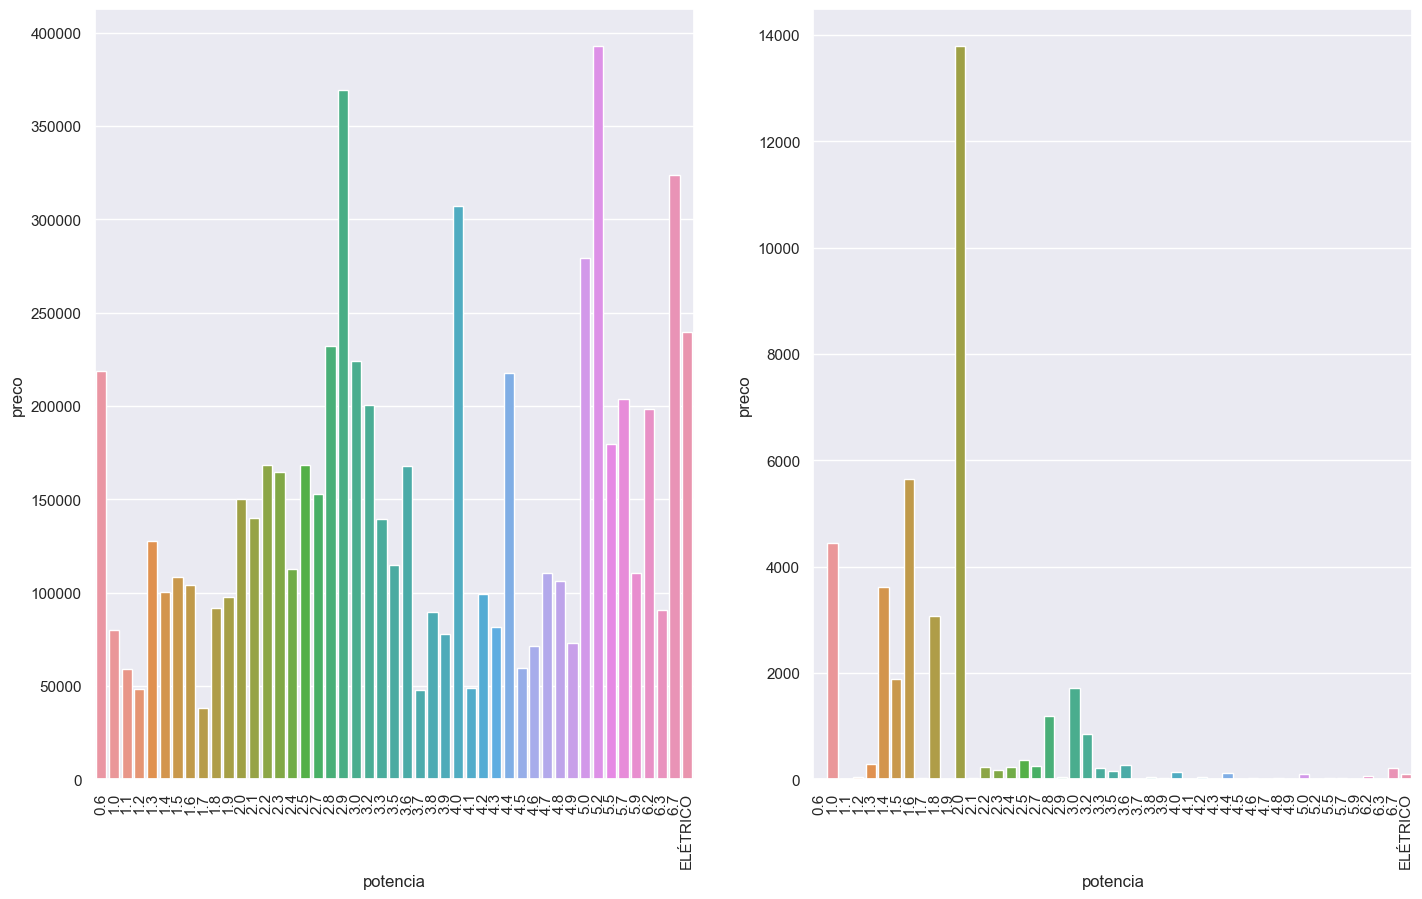

In [749]:
# potencia ( FREQUENCY ENCODING  )

# realizamos um split da feature version e detectamos outras possíveis

# potencia sum
plt.subplot(1 ,2 ,1 )
aux00 = df1[['potencia' , 'preco']].groupby('potencia').mean().reset_index()
sns.barplot( x='potencia', y='preco', data=aux00 );
plt.xticks( rotation=90 );

#potencia count
plt.subplot(1 ,2 ,2 )
aux01 = df1[['potencia' , 'preco']].groupby('potencia').count().reset_index()
sns.barplot( x='potencia', y='preco', data=aux01 );
plt.xticks( rotation=90 ); 

### 1.5.2.2. Categorical Attributes COMBUSTIVEL

In [539]:
df1['teste'] = df1['versao'].str.split(' ', 1, expand = True)[0]
df1['teste1'] = df1['versao'].str.split(' ', 2, expand = True)[1]
df1['teste2'] = df1['versao'].str.split(' ', 3, expand = True)[2]
df1['teste3'] = df1['versao'].str.split(' ', 4, expand = True)[3]
df1['teste4'] = df1['versao'].str.split(' ', 5, expand = True)[4]
df1['teste5'] = df1['versao'].str.split(' ', 6, expand = True)[5]
df1['teste6'] = df1['versao'].str.split(' ', 7, expand = True)[6]
df1['teste7'] = df1['versao'].str.split(' ', 8, expand = True)[7]
df1['teste8'] = df1['versao'].str.split(' ', 9, expand = True)[8]
df1['teste9'] = df1['versao'].str.split(' ', 10, expand = True)[9]

In [573]:
df1['combustivel'] = df1['teste2'].apply(lambda x: 'gasolina' if x == 'GASOLINA' else 'diesel' if x == 'DIESEL' else 'flex' if x == 'FLEX' else 0)


In [574]:
x = lambda x: 'gasolina' if x['teste3'] == 'GASOLINA' else 'diesel' if x['teste3'] == 'DIESEL' else 'flex' if x['teste3'] == 'FLEX' else x['combustivel']
df1['combustivel'] = df1.apply( x , axis=1)


In [576]:
x = lambda x: 'gasolina' if x['teste4'] == 'GASOLINA' else 'diesel' if x['teste4'] == 'DIESEL' else 'flex' if x['teste4'] == 'FLEX' else x['combustivel']
df1['combustivel'] = df1.apply( x , axis=1)

In [578]:
x = lambda x: 'gasolina' if x['teste5'] == 'GASOLINA' else 'diesel' if x['teste5'] == 'DIESEL' else 'flex' if x['teste5'] == 'FLEX' else x['combustivel']
df1['combustivel'] = df1.apply( x , axis=1)

In [580]:
x = lambda x: 'gasolina' if x['teste6'] == 'GASOLINA' else 'diesel' if x['teste6'] == 'DIESEL' else 'flex' if x['teste6'] == 'FLEX' else x['combustivel']
df1['combustivel'] = df1.apply( x , axis=1)

In [582]:
x = lambda x: 'gasolina' if x['teste7'] == 'GASOLINA' else 'diesel' if x['teste7'] == 'DIESEL' else 'flex' if x['teste7'] == 'FLEX' else x['combustivel']
df1['combustivel'] = df1.apply( x , axis=1)

In [584]:
x = lambda x: 'gasolina' if x['teste8'] == 'GASOLINA' else 'diesel' if x['teste8'] == 'DIESEL' else 'flex' if x['teste8'] == 'FLEX' else x['combustivel']
df1['combustivel'] = df1.apply( x , axis=1)

In [586]:
x = lambda x: 'gasolina' if x['teste9'] == 'GASOLINA' else 'diesel' if x['teste9'] == 'DIESEL' else 'flex' if x['teste9'] == 'FLEX' else x['combustivel']
df1['combustivel'] = df1.apply( x , axis=1)

In [587]:
df1[['id', 'combustivel']].groupby('combustivel').count()

id
combustivel       
0             3445
diesel        5900
flex         19749
gasolina     10352

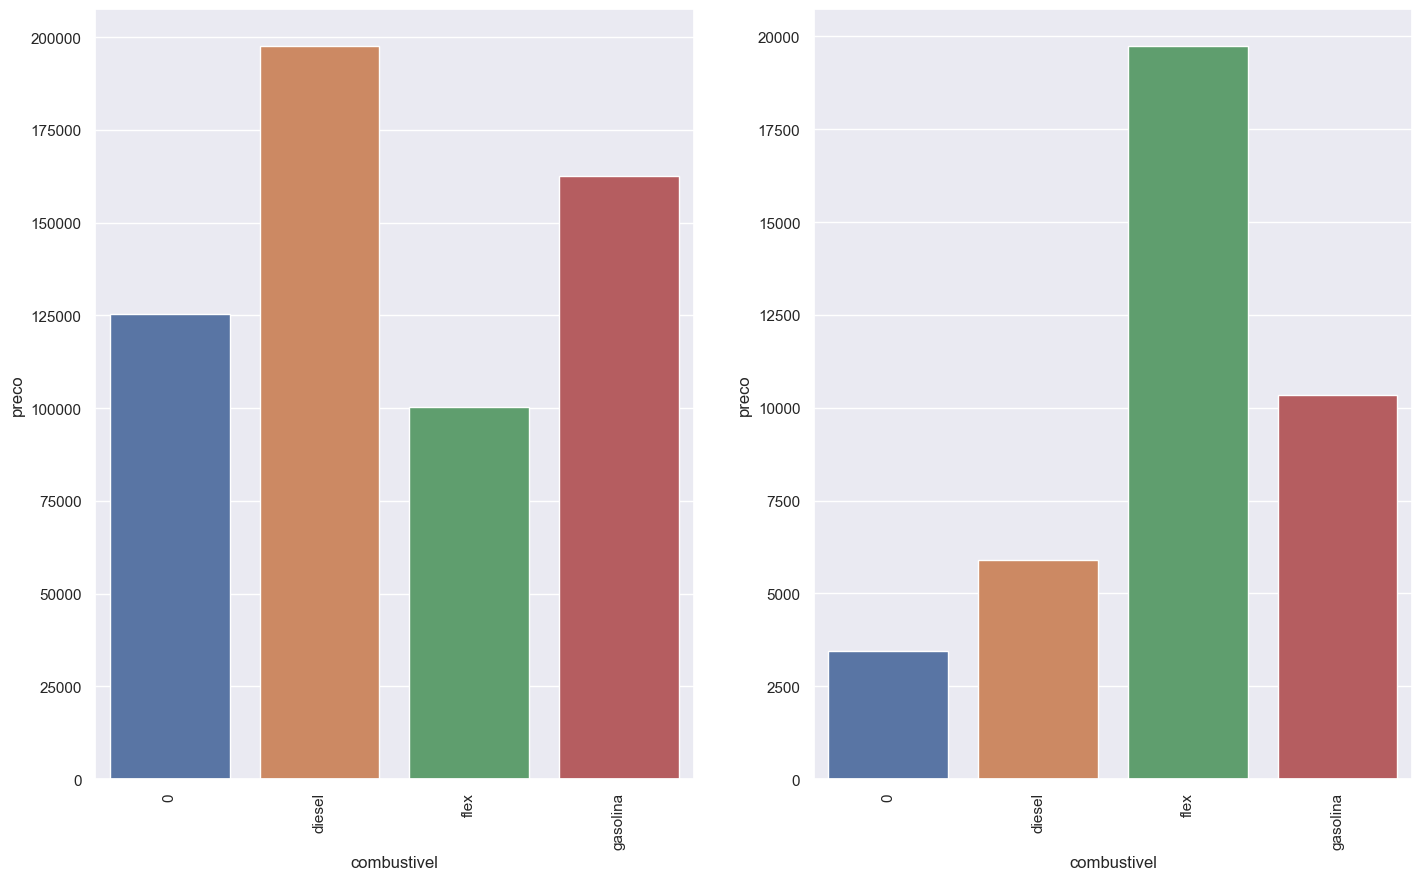

In [588]:
# combustivel
plt.subplot(1 ,2 ,1 )
aux00 = df1[['combustivel' , 'preco']].groupby('combustivel').mean().reset_index()
sns.barplot( x='combustivel', y='preco', data=aux00 );
plt.xticks( rotation=90 );
#combustivel count
plt.subplot(1 ,2 ,2 )
aux01 = df1[['combustivel' , 'preco']].groupby('combustivel').count().reset_index()
sns.barplot( x='combustivel', y='preco', data=aux01 );
plt.xticks( rotation=90 );

### 1.5.2.3. ESTUDO DA TAXA DE DEPRECIACAO

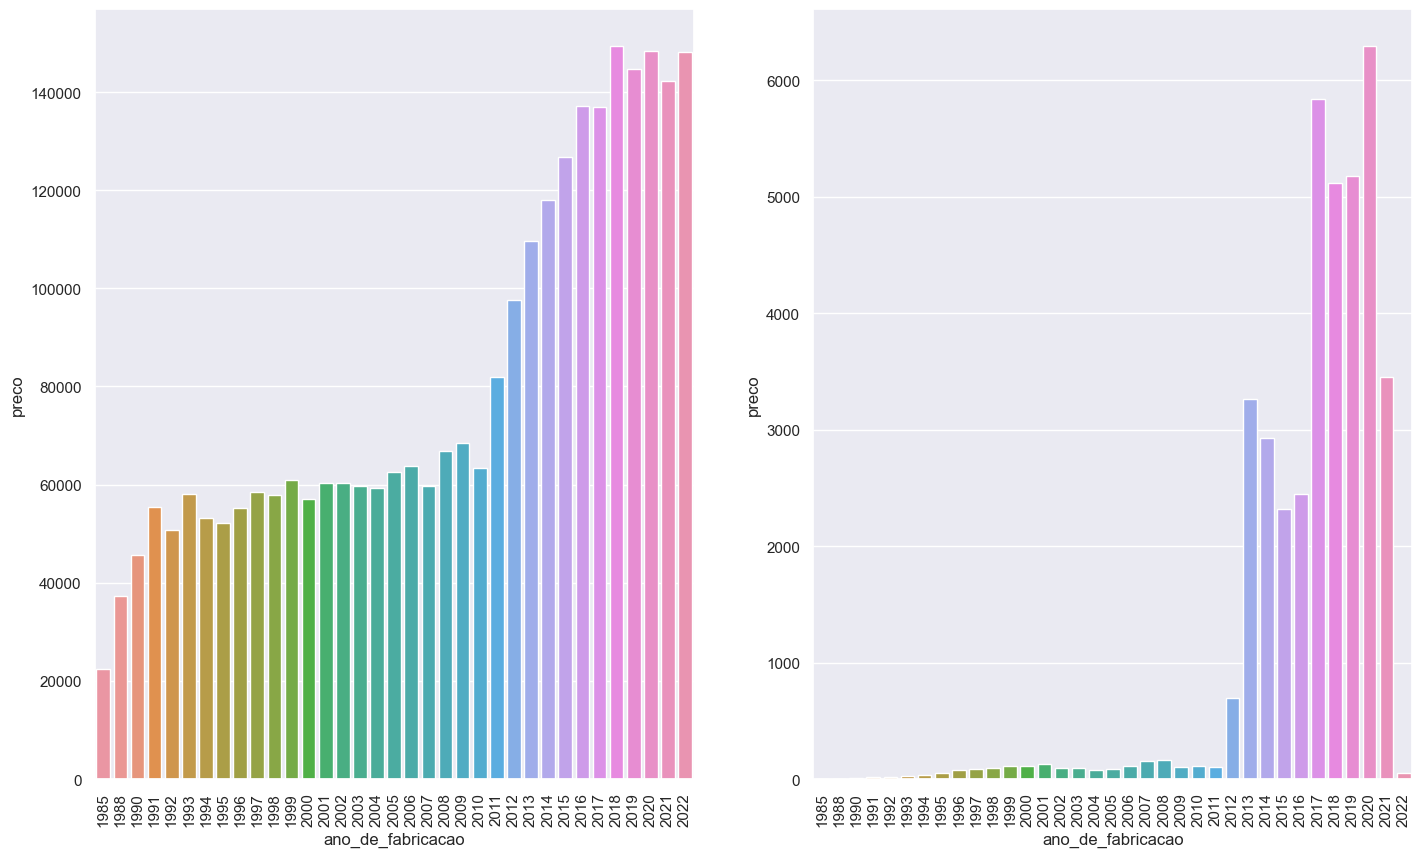

In [709]:
#ano de fabricacao x marca ( depreciacao )
plt.subplot(1 ,2 ,1 )
aux00 = df1[['ano_de_fabricacao' , 'preco']].groupby('ano_de_fabricacao').mean().reset_index()
sns.barplot( x='ano_de_fabricacao', y='preco', data=aux00 );
plt.xticks( rotation=90 );
#marca count
plt.subplot(1 ,2 ,2 )
aux01 = df1[['ano_de_fabricacao' , 'preco']].groupby('ano_de_fabricacao').count().reset_index()
sns.barplot( x='ano_de_fabricacao', y='preco', data=aux01 );
plt.xticks( rotation=90 );

### 1.5.2.1. Categorical Attributes Correlation

Feature: attr_veiculo_ipva_pago              |████████  | [ 81%]   02:53 -> (00:41 left)
Feature: attr_veiculo_alienado               |█████████▋| [ 97%]   00:10 -> (00:00 left)                      /Users/thiago/Thiago/Data_Science/myrepos/mobility_cars_hack02/mobcars_env/lib/python3.10/site-packages/sweetviz/series_analyzer.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  value_counts_without_nan = pd.Series()
Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)

Report mobilitycars_data/SWEETVIZ_REPORT.html was generated.



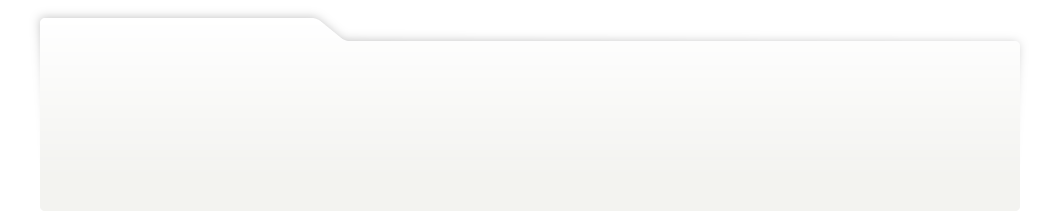
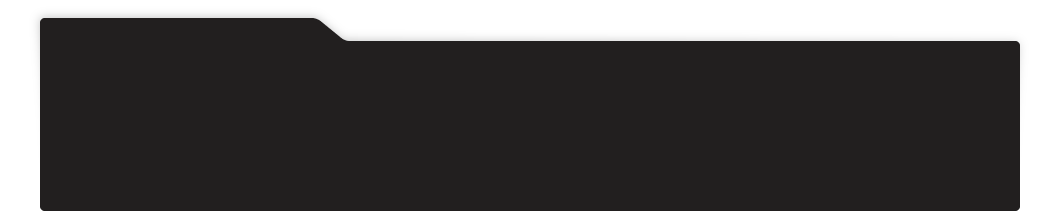
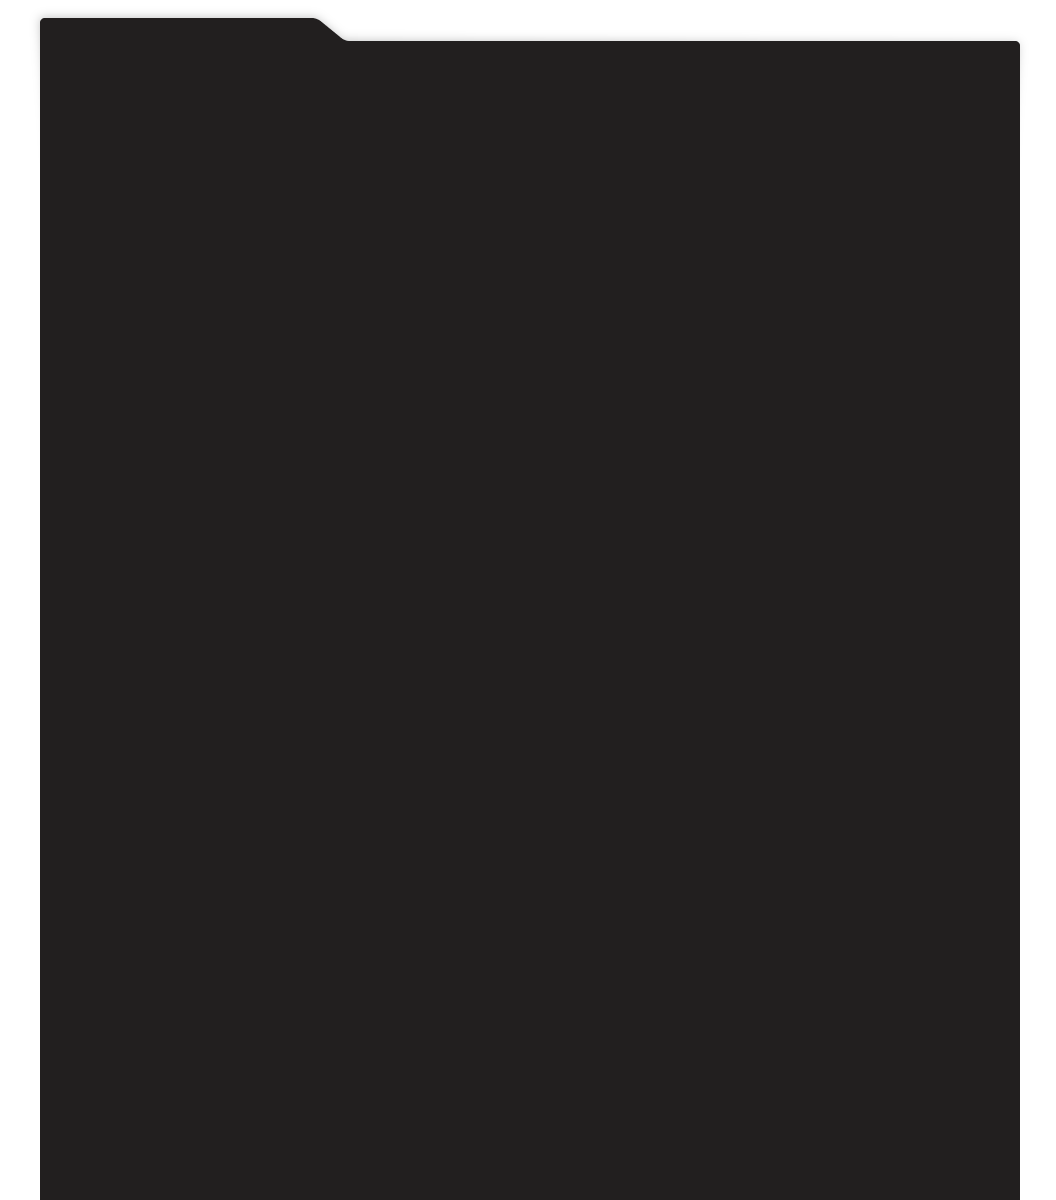
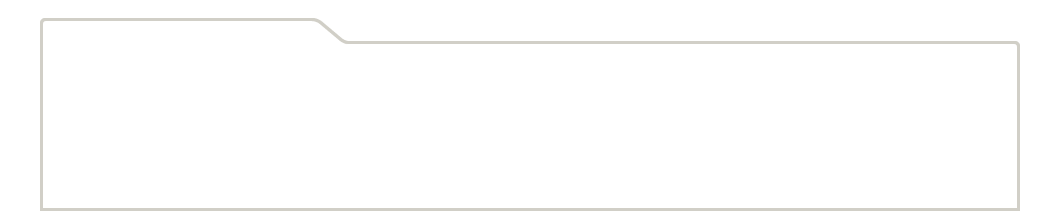
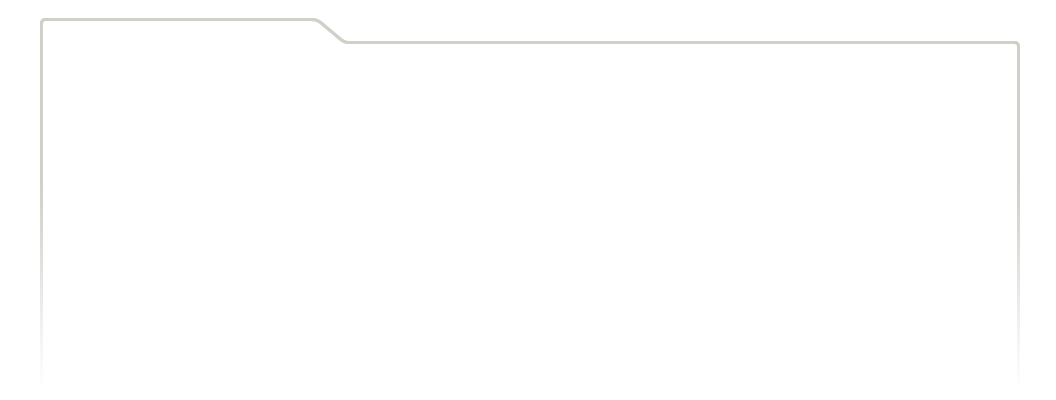
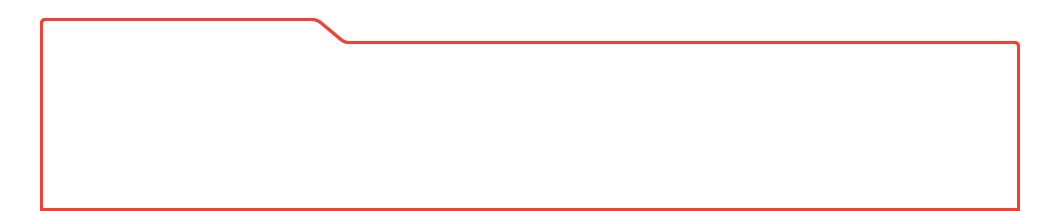
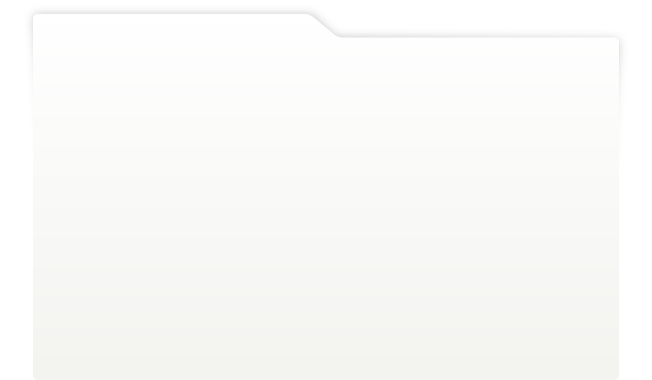
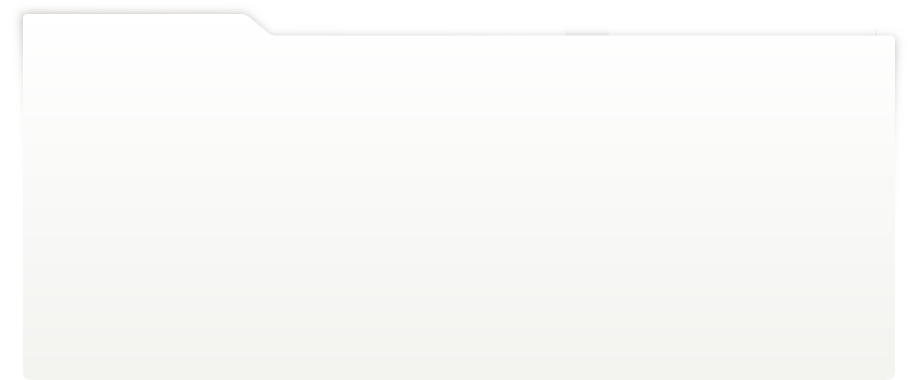
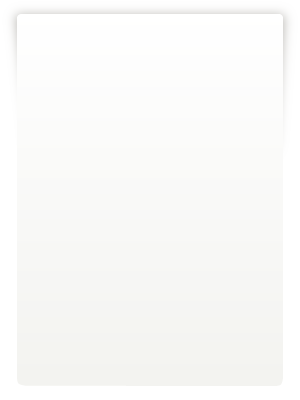
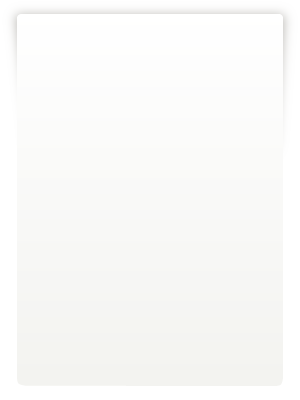
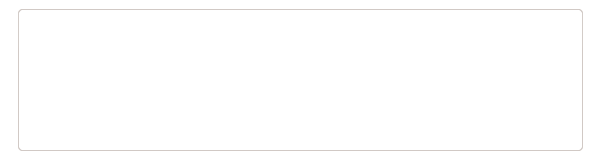
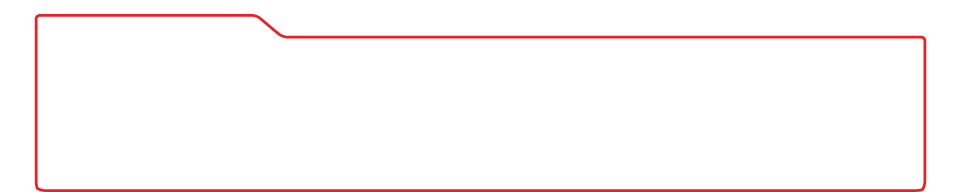
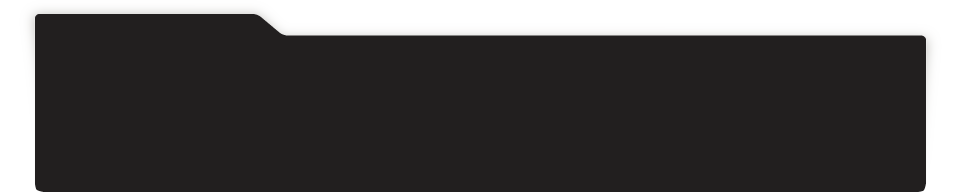
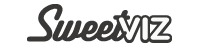
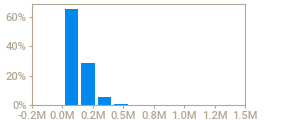
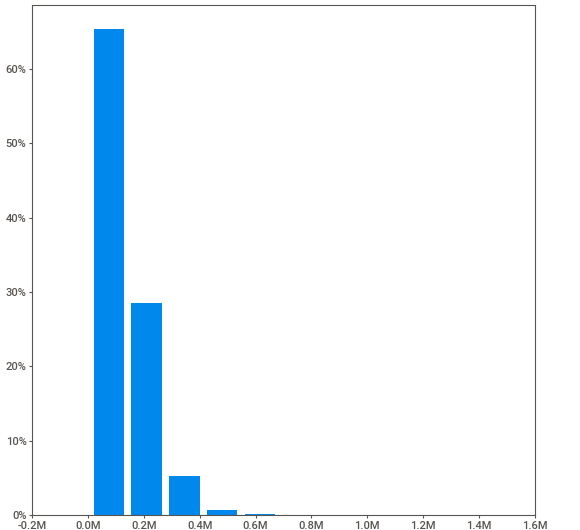
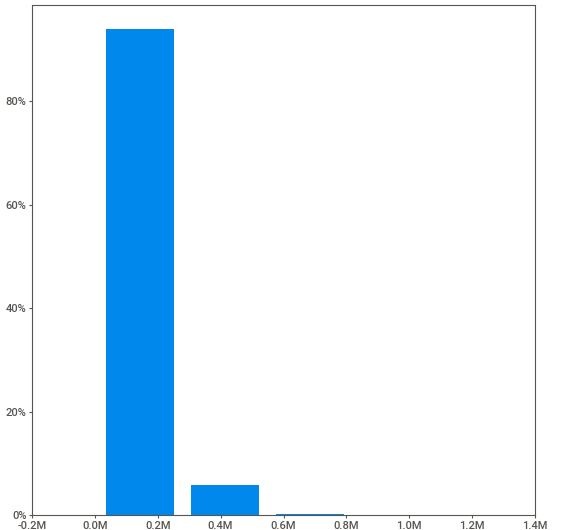
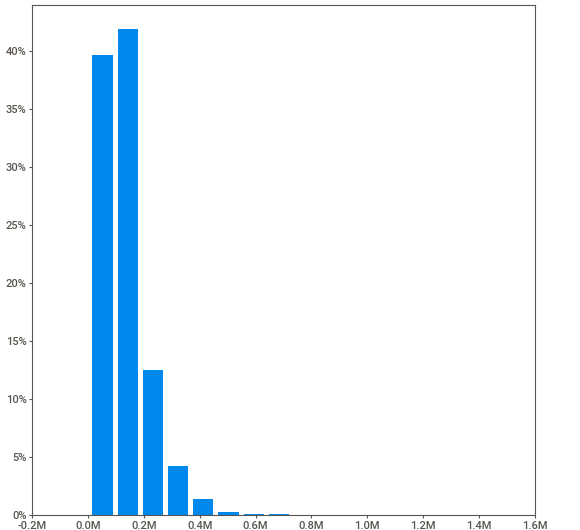
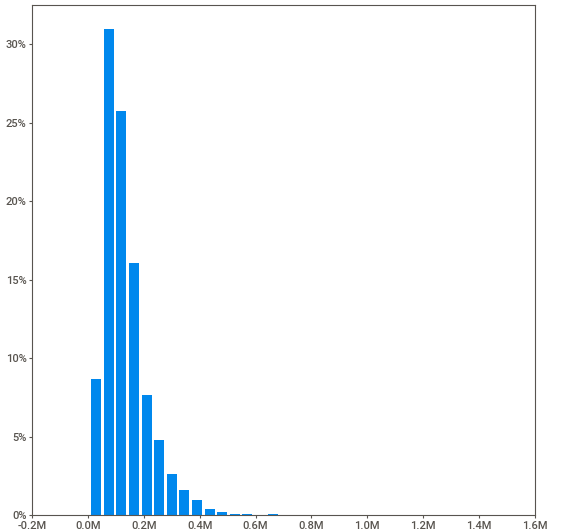
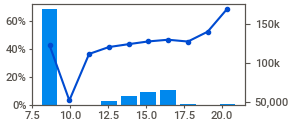
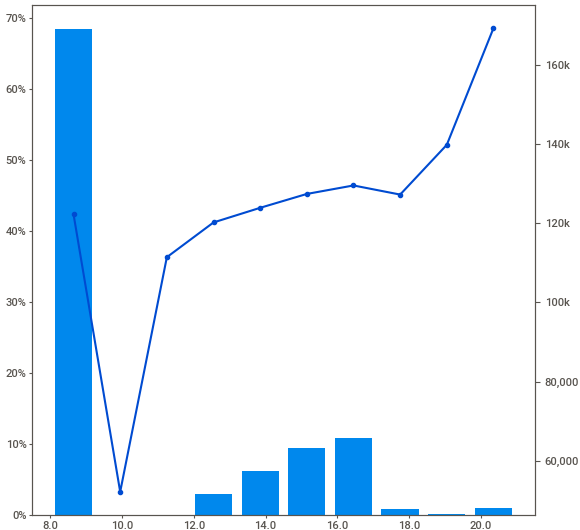
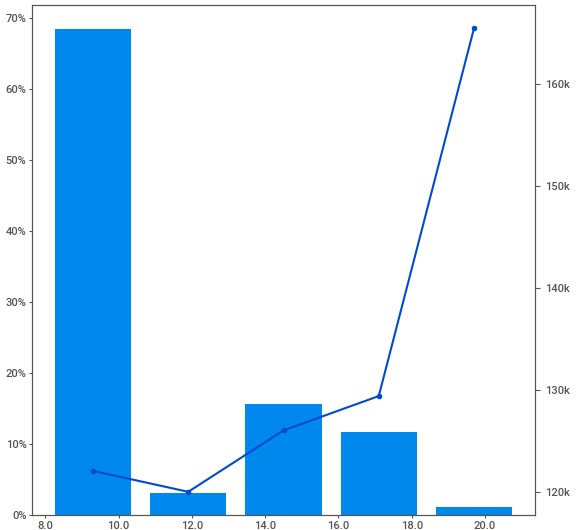
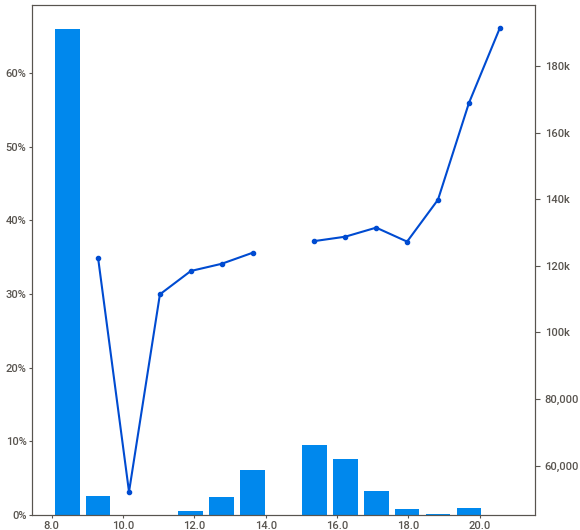
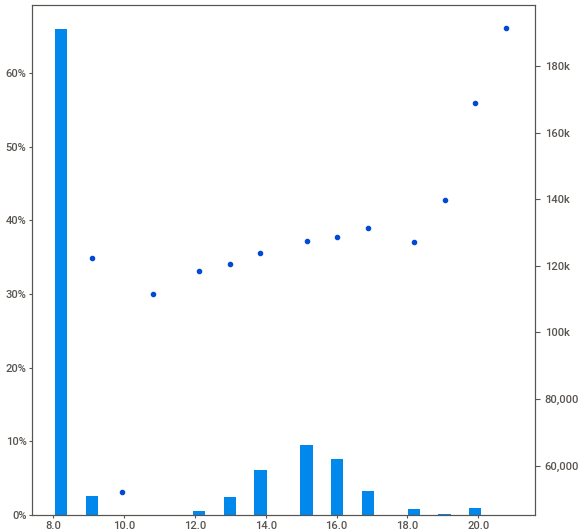
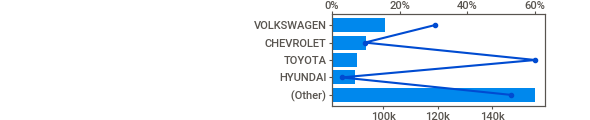
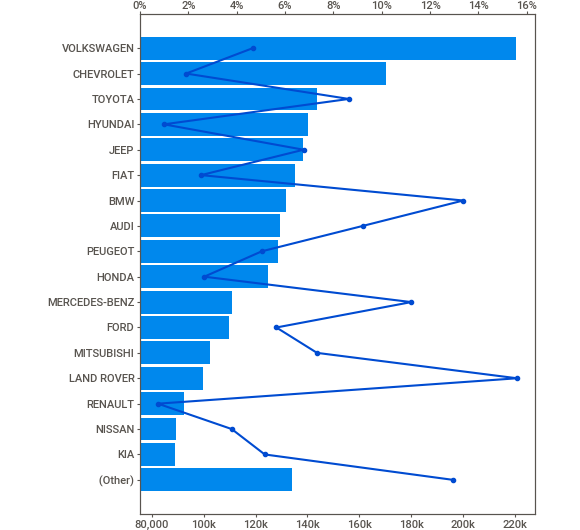
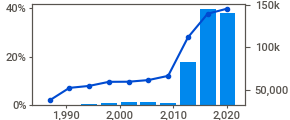
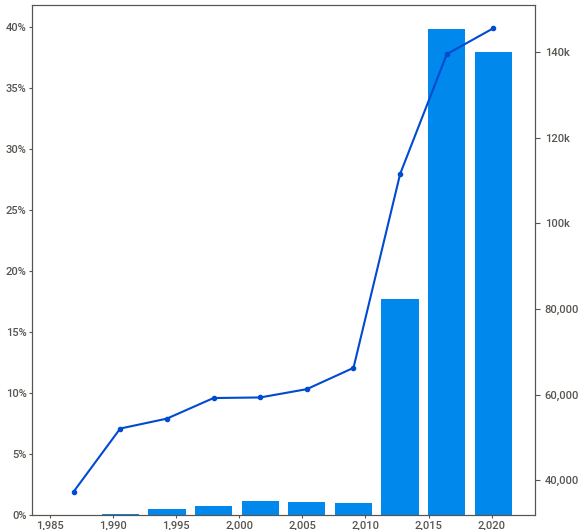
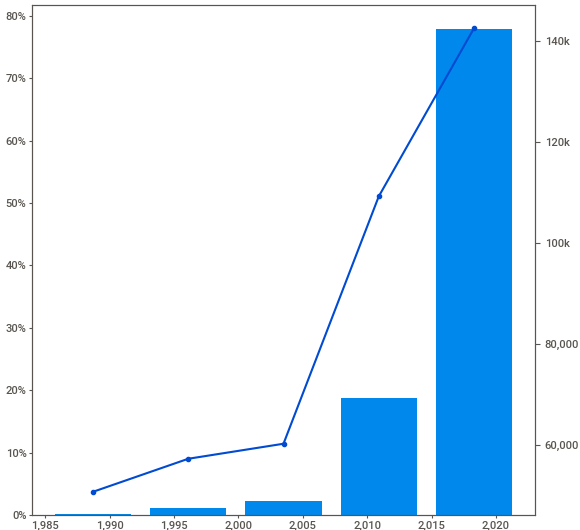
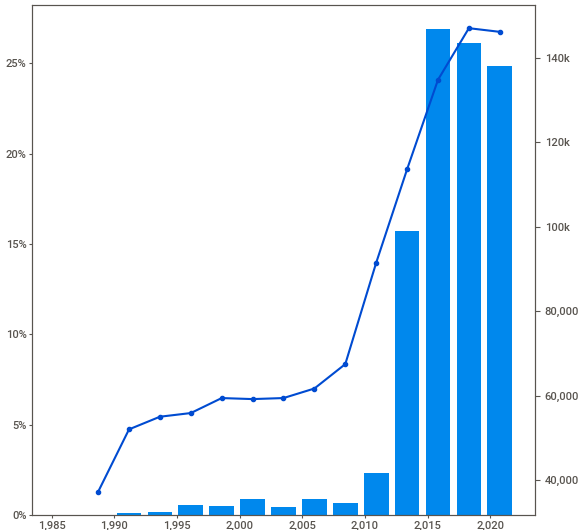
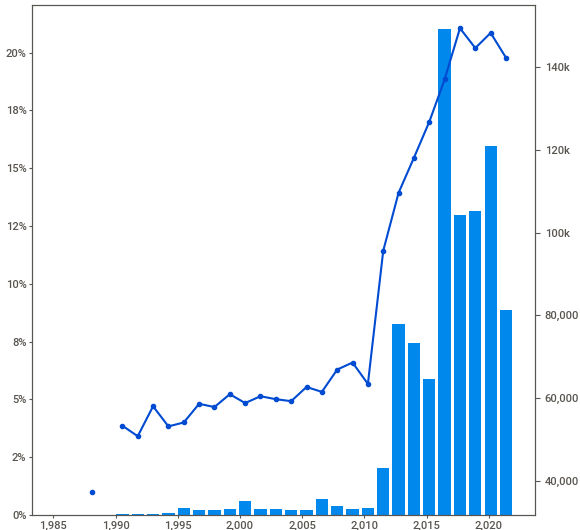
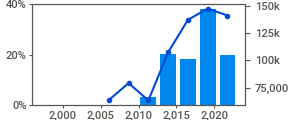
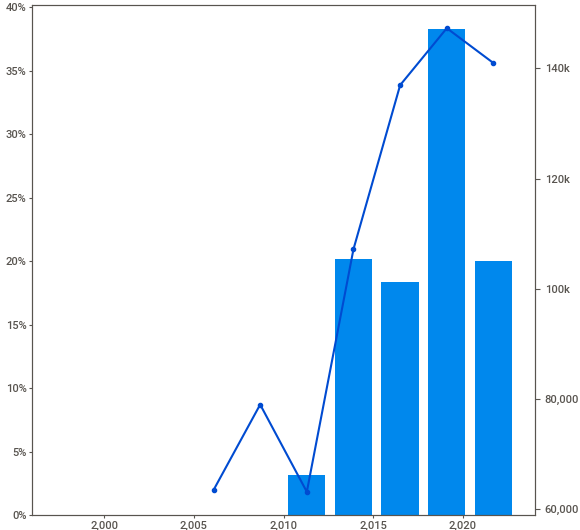
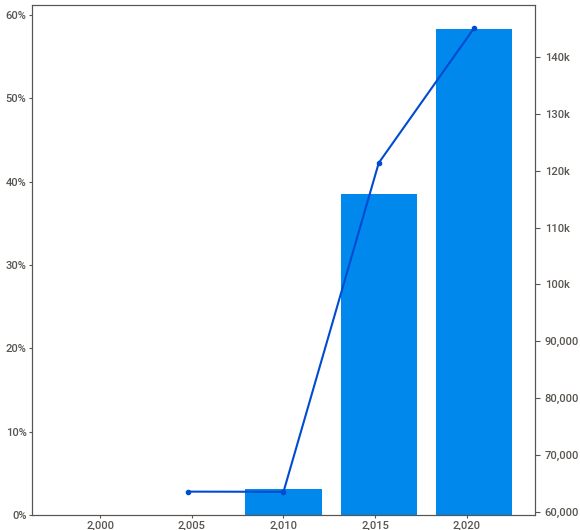
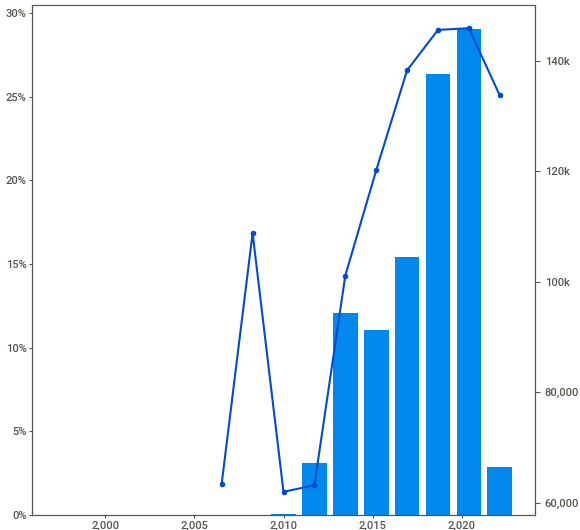
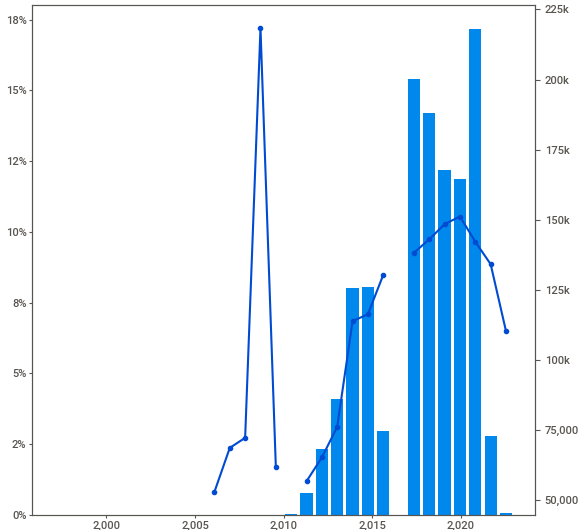
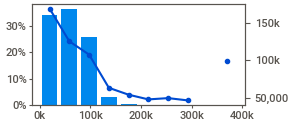
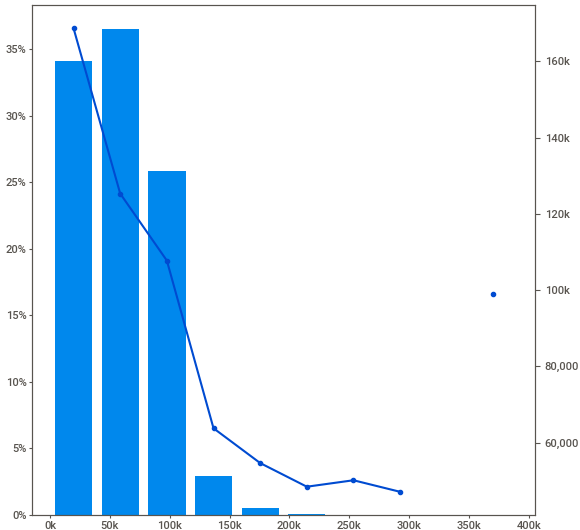
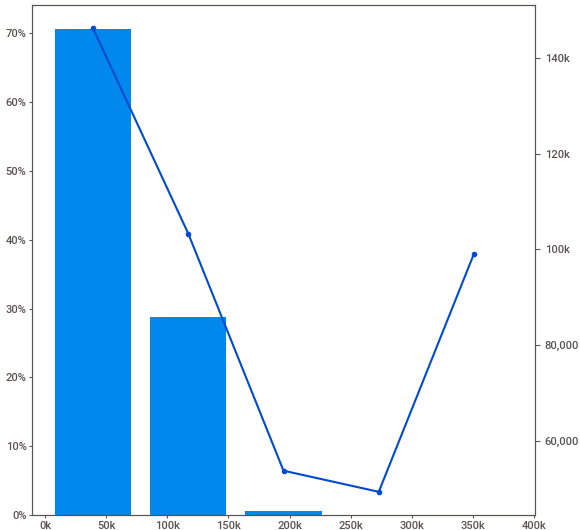
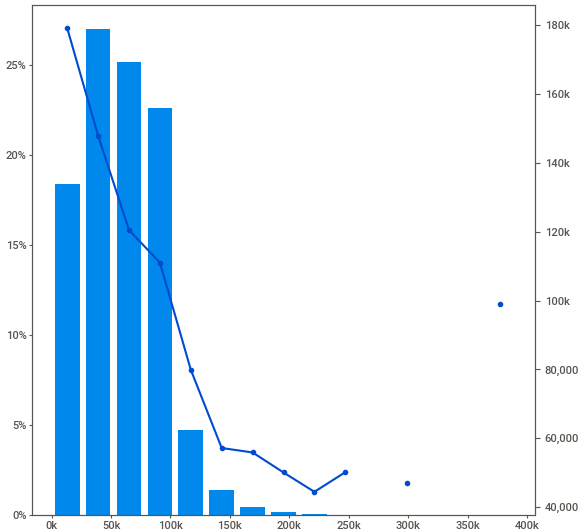
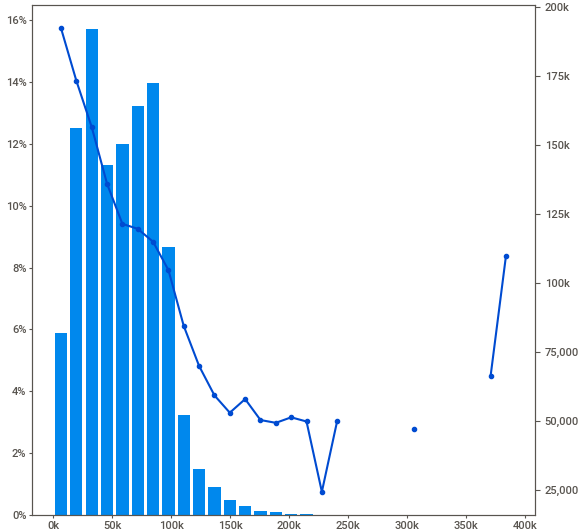
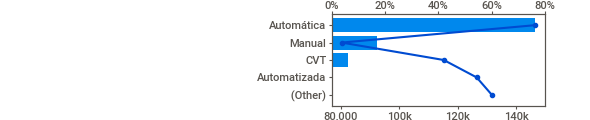
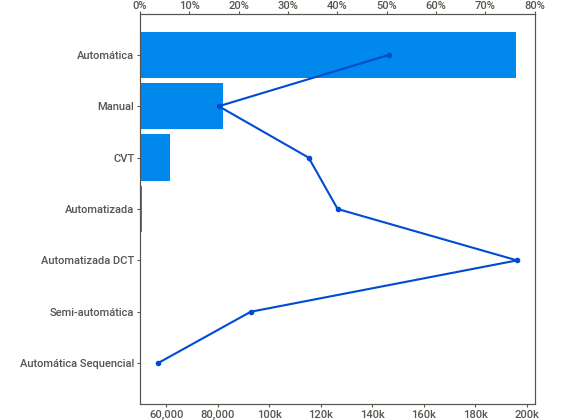
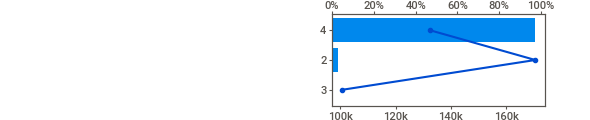
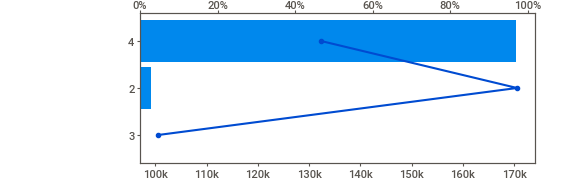
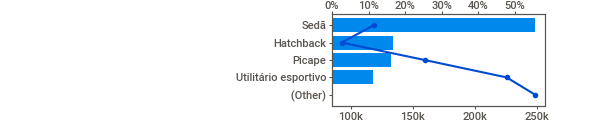
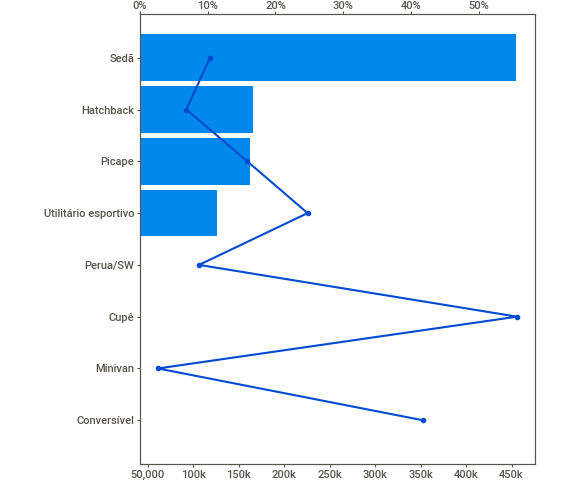
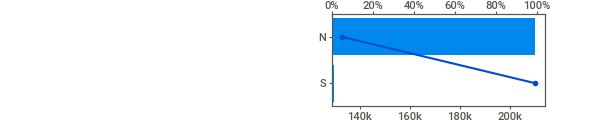
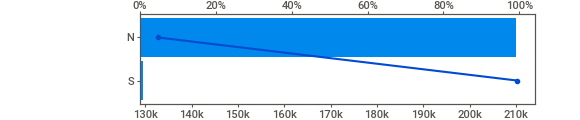
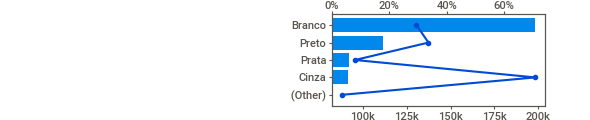
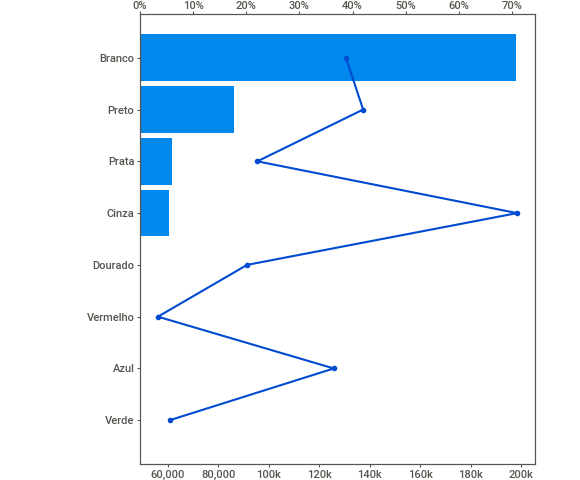
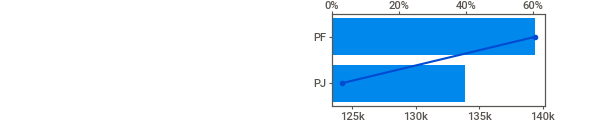
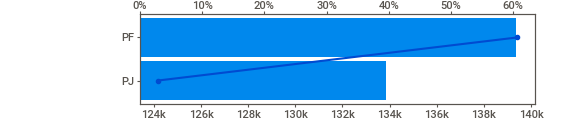
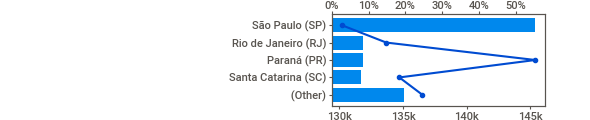
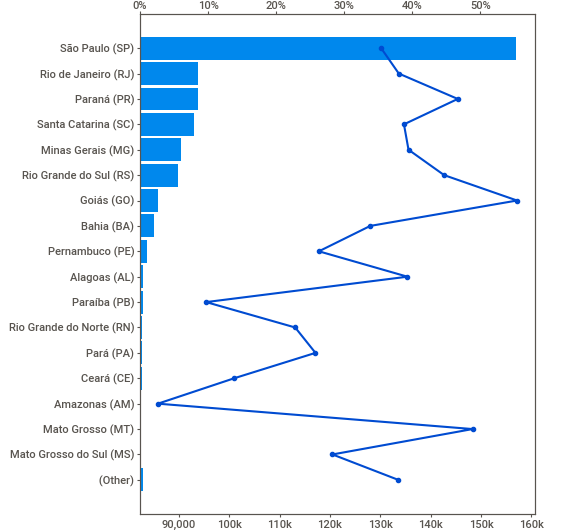
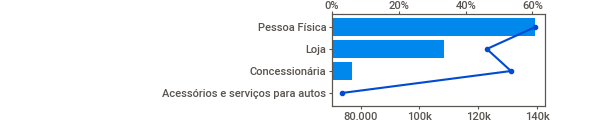
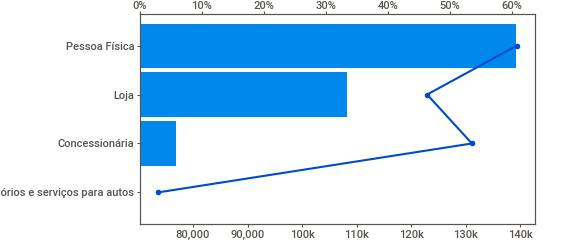
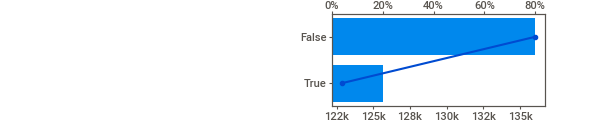
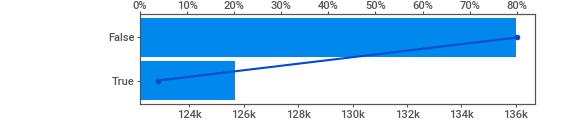
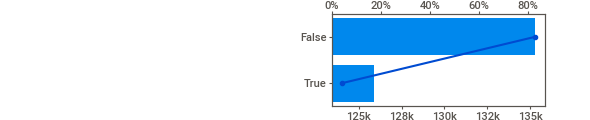
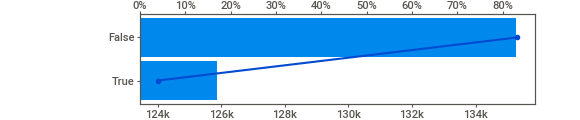
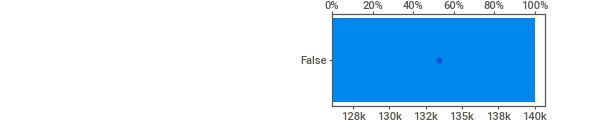
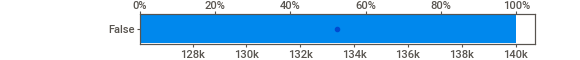
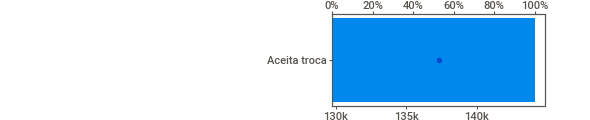
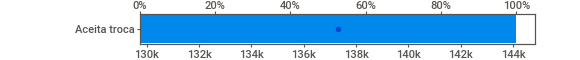
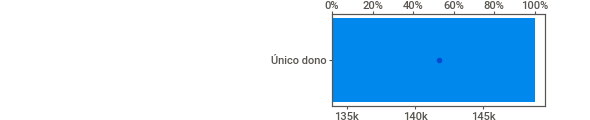
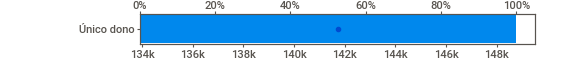
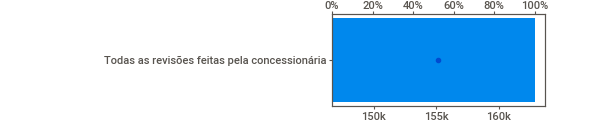
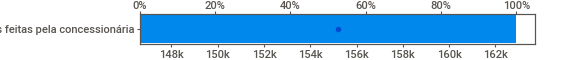
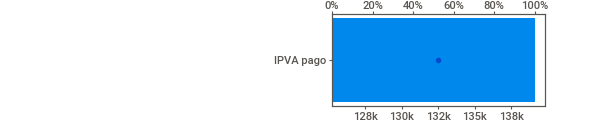
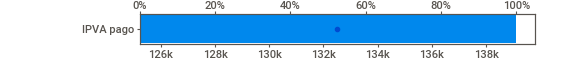
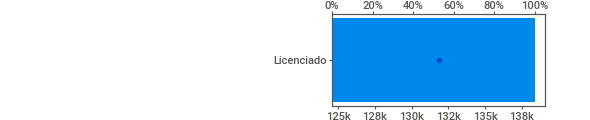
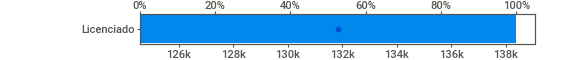
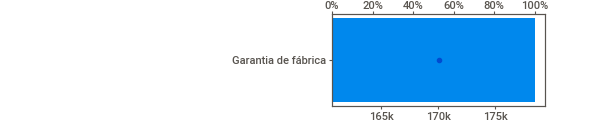
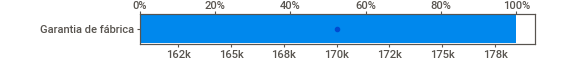
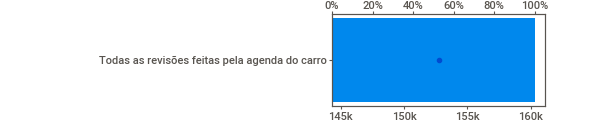
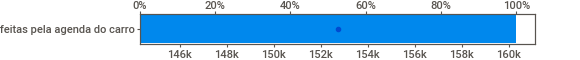
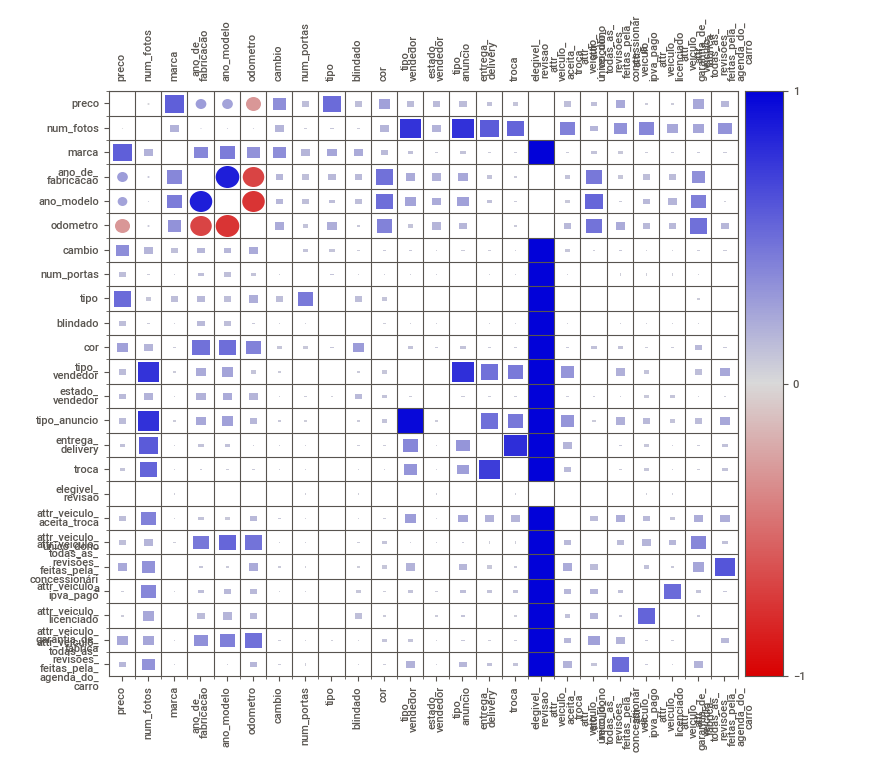
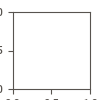

In [390]:
report = sv.analyze(df1, target_feat='preco')
report.show_html(filepath='mobilitycars_data/SWEETVIZ_REPORT.html',open_browser=False)
# display on the nb
report.show_notebook(w=None, h=None,scale=None,layout='vertical')

# 2.0. FEATURE ENGINEERING

In [798]:
df2 = df1.copy()
df2.columns

Index(['id', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao',
       'attr_veiculo_aceita_troca', 'attr_veiculo_unico_dono',
       'attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fabrica',
       'attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro',
       'attr_veiculo_alienado', 'preco', 'potencia'],
      dtype='object')

In [799]:
# REMOVER LAMBO para evitar OUTLIERS
df2 = df2.query("marca != 'LAMBORGHINI' ").copy()

In [800]:
fe_marca = df2.groupby('marca').size() / len(df2)
x = lambda x: fe_marca[x] if x in fe_marca.index else 0 
df2['marca'] = df2['marca'].apply(x)

#le_marca = preprocessing.LabelEncoder()
#df2['marca'] = le_marca.fit_transform(df2['marca'])

fe_modelo = df2.groupby('modelo').size() / len(df2)
x = lambda x: fe_modelo[x] if x in fe_modelo.index else 0 
df2['modelo'] = df2['modelo'].apply(x)

le_cambio = preprocessing.LabelEncoder()
df2['cambio'] = le_cambio.fit_transform(df2['cambio'])

le_tipo = preprocessing.LabelEncoder()
df2['tipo'] = le_tipo.fit_transform(df2['tipo'])

le_blindado = preprocessing.LabelEncoder()
df2['blindado'] = le_blindado.fit_transform(df2['blindado'])

# para v2 testar o ordinal enconding 
#from sklearn.preprocessing import OrdinalEncoder
#encoder = OrdinalEncoder(handle_unknown='ignore', unknown_value=np.nan)
fe_cor = df2.groupby('cor').size() / len(df2)
x = lambda x: fe_cor[x] if x in fe_cor.index else 0 
df2['cor'] = df2['cor'].apply(x)

#le_cor = preprocessing.LabelEncoder()
#df2['cor'] = le_cor.fit_transform(df2['cor'])

le_tipo_anuncio = preprocessing.LabelEncoder()
df2['tipo_anuncio'] = le_tipo_anuncio.fit_transform(df2['tipo_anuncio'])

le_entrega_delivery = preprocessing.LabelEncoder()
df2['entrega_delivery'] = le_entrega_delivery.fit_transform(df2['entrega_delivery'])

le_troca = preprocessing.LabelEncoder()
df2['troca'] = le_troca.fit_transform(df2['troca'])

df2['attr_veiculo_aceita_troca'] = df2['attr_veiculo_aceita_troca'].replace("Aceita troca", 1)

df2['attr_veiculo_unico_dono'] = df2['attr_veiculo_unico_dono'].replace("Único dono", 1)

df2['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria'] = df2['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria'].replace("Todas as revisões feitas pela concessionária", 1)

df2['attr_veiculo_garantia_de_fabrica'] = df2['attr_veiculo_garantia_de_fabrica'].replace("Garantia de fábrica", 1)

# fe_potencia = df2.groupby('potencia').size() / len(df2)
# x = lambda x: fe_potencia[x] if x in fe_potencia.index else 0 
# df2['potencia'] = df2['potencia'].apply(x)

#Yeo-johnson não converte valores string
df2['potencia'] = df2['potencia'].replace('ELÉTRICO',2.8)
power_potencia = PowerTransformer(method='yeo-johnson', standardize=True)
df2['potencia'] = power_potencia.fit_transform(df2[['potencia']])


mms_ano_fabricacao = MinMaxScaler()
df2['ano_de_fabricacao'] = mms_ano_fabricacao.fit_transform(df2[['ano_de_fabricacao']])

mms_ano_modelo = MinMaxScaler()
df2['ano_modelo'] = mms_ano_modelo.fit_transform(df2[['ano_modelo']])

# mms_odometro = MinMaxScaler()
# df2['odometro'] = mms_odometro.fit_transform(df2[['odometro']])

# odometro
df2['odometro'] = df2['odometro'].apply( lambda x: 'seminovo' if x <= 50000 else 'usado' if 50000 <= x <= 150000 else 'velho'  )

# le_combustivel = preprocessing.LabelEncoder()
# df2['combustivel'] = df2['combustivel'].astype(str)
# df2['combustivel'] = le_combustivel.fit_transform(df2['combustivel'])

In [771]:
df2.head()

id  num_fotos     marca    modelo  \
0  105869496634249611881157692933406072990        8.0  0.155660  0.024287   
1   14165644411757892901957277406025007093        8.0  0.005375  0.001724   
2   78515656948521351316652580664682810356       14.0  0.101914  0.020712   
3   36797041166808090517929207429817328298        8.0  0.011915  0.001166   
4  338618517701891995317200439137014723900        8.0  0.009203  0.001192   

                                              versao  ano_de_fabricacao  \
0  2.0 TRENDLINE 4X4 CD 16V TURBO INTERCOOLER DIE...           0.864865   
1    2.0 16V TURBO DIESEL PRESTIGE AWD 4P AUTOMÁTICO           0.864865   
2                      1.8 LT 16V FLEX 4P AUTOMÁTICO           0.729730   
3                    2.0 16V H4 GASOLINA BOXSTER PDK           0.945946   
4   2.0 INSCRIPTION TURBO GASOLINA 4P 4X4 AUTOMÁTICO           0.810811   

   ano_modelo  odometro  cambio  num_portas  ...  attr_veiculo_aceita_troca  \
0    0.769231  seminovo       2           4  ...                        1.0   
1    0.769231  seminovo       2           4  ...                        1.0   
2    0.615385     usado       2           4  ...                        1.0   
3    0.923077  seminovo       2           2  ...                        1.0   
4    0.730769  seminovo       2           4  ...                        1.0   

   attr_veiculo_unico_dono  \
0                      NaN   
1                      NaN   
2                      NaN   
3                      NaN   
4                      NaN   

   attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria  \
0                                                1.0           
1                                                1.0           
2                                                NaN           
3                                                1.0           
4                                                1.0           

  attr_veiculo_ipva_pago attr_veiculo_licenciado  \
0              IPVA pago              Licenciado   
1              IPVA pago                     NaN   
2                    NaN                     NaN   
3                    NaN                     NaN   
4                    NaN                     NaN   

  attr_veiculo_garantia_de_fabrica  \
0                              NaN   
1                              NaN   
2                              NaN   
3                              NaN   
4                              NaN   

   attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro  \
0      Todas as revisões feitas pela agenda do carro            
1      Todas as revisões feitas pela agenda do carro            
2                                                NaN            
3                                                NaN            
4      Todas as revisões feitas pela agenda do carro            

   attr_veiculo_alienado          preco  potencia  
0                    NaN  123231.992782  0.340103  
1                    NaN  272076.023576  0.340103  
2                    NaN   53411.539492  0.016184  
3                    NaN  299697.071937  0.340103  
4                    NaN  255164.344178  0.340103  

[5 rows x 30 columns]

In [801]:
aux1 = df2[['id' , 'odometro']].groupby('odometro').count().reset_index()
aux1

odometro     id
0  seminovo  17232
1     usado  21892
2     velho    321

/Users/thiago/Thiago/Data_Science/myrepos/mobility_cars_hack02/mobcars_env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


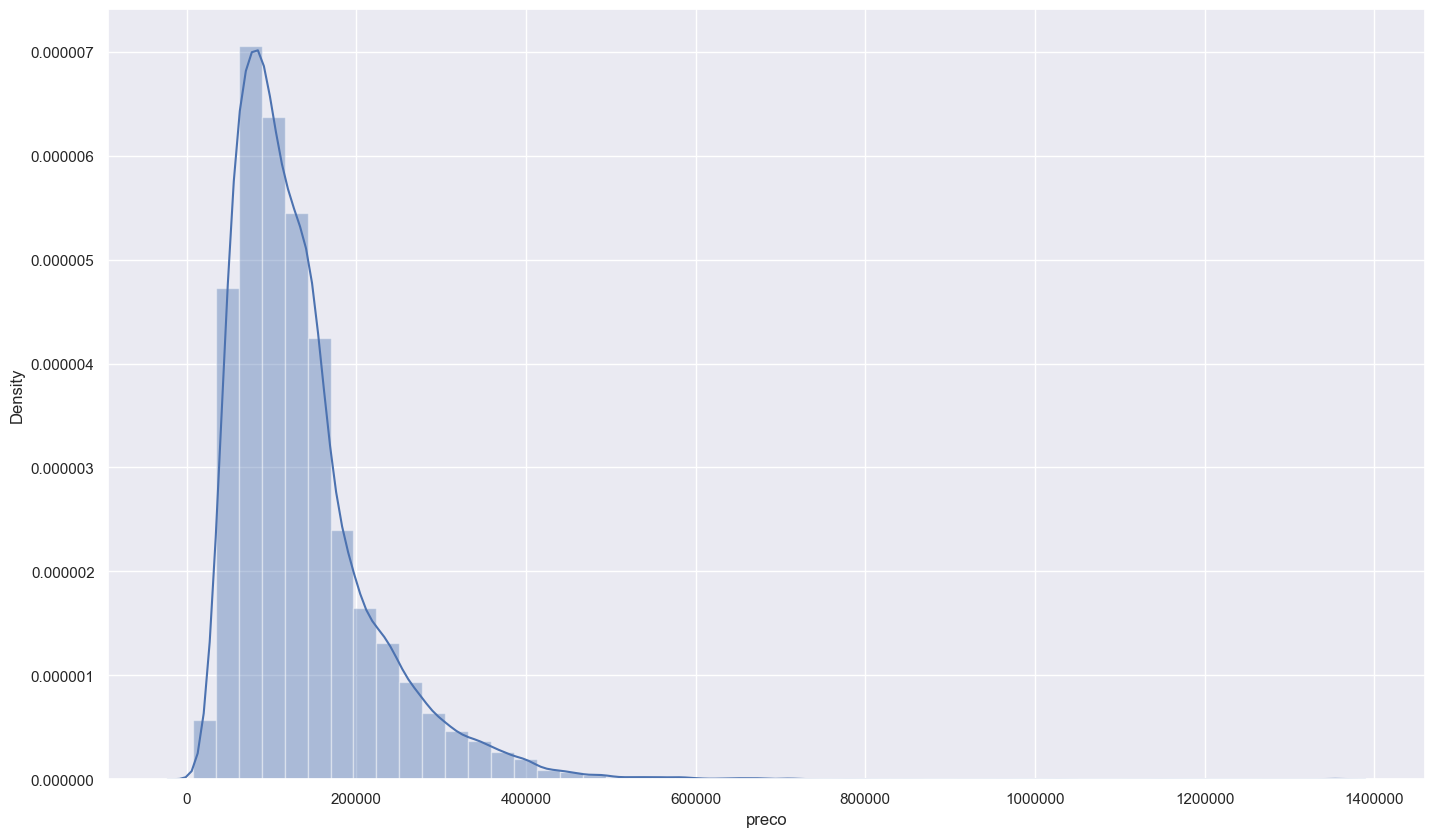

In [758]:
sns.distplot( df1['preco']);

/Users/thiago/Thiago/Data_Science/myrepos/mobility_cars_hack02/mobcars_env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


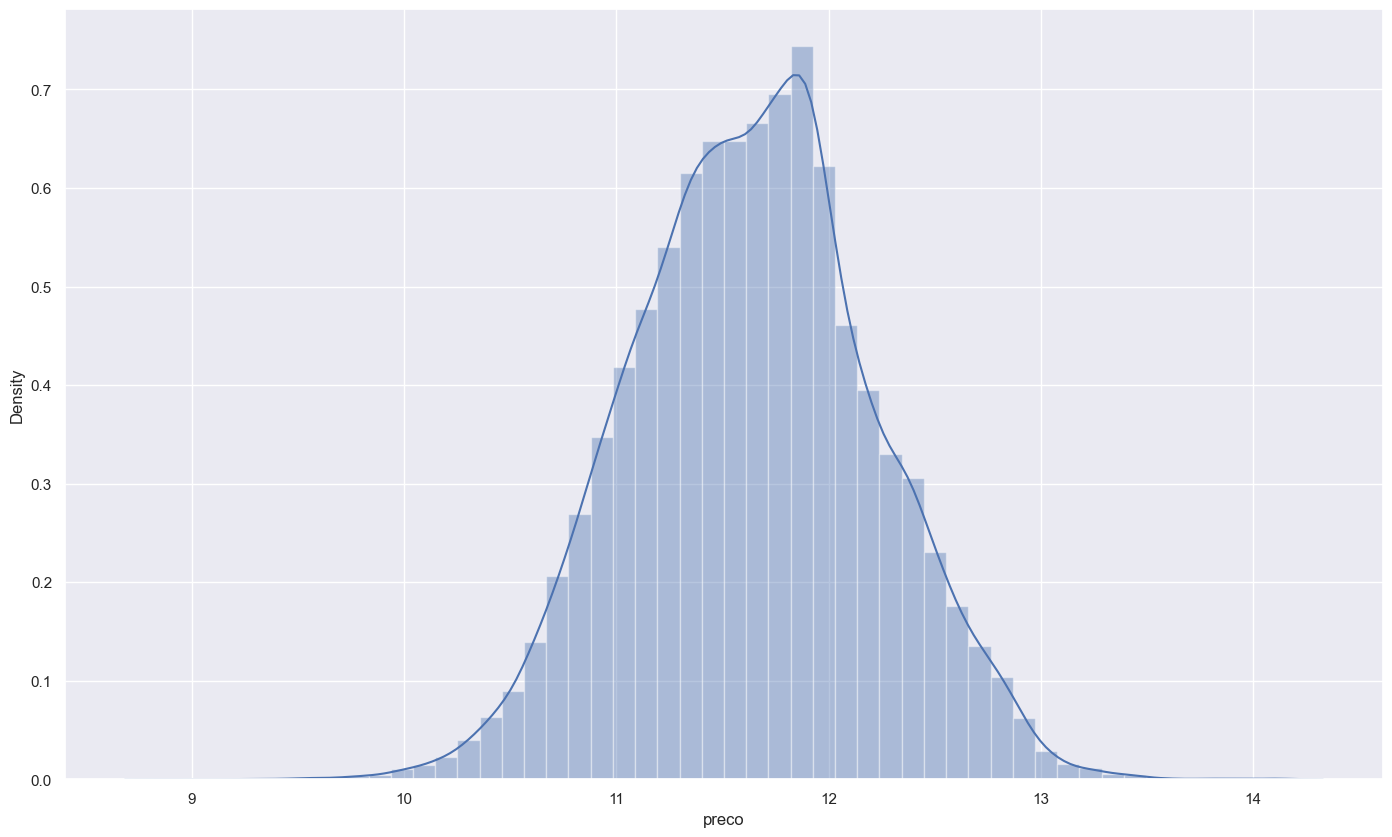

In [759]:
df2['preco'] = np.log1p( df2['preco'] )

sns.distplot( df2['preco']);

# 3.0 COLUMNS SELECTION

In [680]:
df3 = df2.copy()

In [681]:
df3.columns

Index(['id', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao',
       'attr_veiculo_aceita_troca', 'attr_veiculo_unico_dono',
       'attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fabrica',
       'attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro',
       'attr_veiculo_alienado', 'preco', 'potencia', 'teste', 'teste1',
       'teste2', 'teste3', 'teste4', 'teste5', 'teste6', 'teste7', 'teste8',
       'teste9', 'teste10', 'combustivel'],
      dtype='object')

In [682]:
df3 = df3[['id', 
          'marca', 
          'modelo', 
          'potencia',
          'combustivel',
          'ano_de_fabricacao',
          'ano_modelo', 
          'odometro', 
          'cambio', 
          'tipo', 
          'blindado', 
          'cor', 
          'tipo_anuncio', 
          'entrega_delivery', 
          'troca', 
          'attr_veiculo_aceita_troca',
          'attr_veiculo_unico_dono','attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria', 
          'attr_veiculo_garantia_de_fabrica', 
          'preco']]

## 3.1. BORUTA FEATURE SELECTION

In [439]:
X_train = df3
y_train = X_train['preco']

# training and test dataset for Boruta
x_train_n = X_train.drop('preco', axis=1).values
y_train_n = y_train.values.ravel()


# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 )

# define boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	10


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	10


In [440]:
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = X_train.drop('preco', axis=1 )
cols_selected_boruta = x_train_fs.iloc[ :, cols_selected ].columns.to_list()

cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

cols_selected_boruta

['marca',
 'modelo',
 'potencia',
 'ano_de_fabricacao',
 'ano_modelo',
 'odometro',
 'cambio',
 'tipo']

# 4.0 MACHINE LEARNING MODELLING

In [684]:
df4 = df3.copy()
df4.head()

id     marca    modelo  potencia  \
0  105869496634249611881157692933406072990  0.163668  0.025536  0.342610   
2   78515656948521351316652580664682810356  0.107157  0.021778  0.081967   
4  338618517701891995317200439137014723900  0.009676  0.001253  0.342610   
5  268137846184182116693379829852805422613  0.067253  0.001306  0.118619   
6  138848917019743940491224582519524808169  0.073037  0.013675  0.150420   

   combustivel  ano_de_fabricacao  ano_modelo  odometro  cambio  tipo  \
0            1           0.864865    0.769231  0.142505       2     4   
2            2           0.729730    0.615385  0.313420       2     5   
4            3           0.810811    0.730769  0.111959       2     6   
5            2           0.891892    0.807692  0.180801       5     1   
6            2           0.837838    0.769231  0.222746       2     1   

   blindado       cor  tipo_anuncio  entrega_delivery  troca  \
0         0  0.167666             3                 0      0   
2         0  0.062642             2                 1      1   
4         0  0.167666             3                 0      0   
5         0  0.714434             3                 0      0   
6         0  0.714434             2                 1      1   

   attr_veiculo_aceita_troca  attr_veiculo_unico_dono  \
0                          1                        0   
2                          1                        0   
4                          1                        0   
5                          0                        1   
6                          1                        0   

   attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria  \
0                                                  1           
2                                                  0           
4                                                  1           
5                                                  1           
6                                                  0           

   attr_veiculo_garantia_de_fabrica          preco  
0                                 0  123231.992782  
2                                 0   53411.539492  
4                                 0  255164.344178  
5                                 0   46583.478757  
6                                 0   51497.914307

In [685]:
X = df4.drop(['preco', 'id'], axis = 1)
y = df4['preco']

In [686]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=1500,
                                  eta=0.01,
                                  max_depth=9, 
                                  subsample=0.5,
                                  colsample_bytree=0.9,
                                  min_child_weight=3 )

# performance
result = cv( df4, 10, model_xgb, verbose=True )
#final_result = pd.concat( [final_result, result] )
result

repeticao 0
repeticao 1
repeticao 2
repeticao 3
repeticao 4
repeticao 5
repeticao 6
repeticao 7
repeticao 8
repeticao 9


MAE
0  24669.29 +/- 179.9

In [688]:
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

# 5.0 HYPERPARAMETER TUNING

In [ ]:
param = {'n_estimators': [ 1500, 1700, 2500, 3000, 3500],
         'eta': [ 0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.5, 0.9],
         'min_child_weight': [3, 8, 15]
         }

In [649]:
max_eval = 5
final_result= pd.DataFrame()

for i in range( max_eval ):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1)[0] for k, v in param.items() }
    print( hp )

    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'],
                                  eta=hp['eta'],
                                  max_depth=hp['max_depth'], 
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'] )

    # performance
    result = cv( df4, 5, model_xgb, verbose=True )
    final_result = pd.concat( [final_result, result] )
    
final_result

{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8}
repeticao 0
repeticao 1
repeticao 2
repeticao 3
repeticao 4
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15}
repeticao 0
repeticao 1
repeticao 2
repeticao 3
repeticao 4
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 8}
repeticao 0
repeticao 1
repeticao 2
repeticao 3
repeticao 4
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3}
repeticao 0
repeticao 1
repeticao 2
repeticao 3
repeticao 4
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}
repeticao 0
repeticao 1
repeticao 2
repeticao 3
repeticao 4


MAE
0  27975.09 +/- 438.84
0  27699.64 +/- 176.98
0  30098.98 +/- 171.98
0  27552.32 +/- 305.39
0  27537.29 +/- 123.19

In [ ]:
final_result

# 6.0. TEST DATA

In [689]:
data_teste = pd.read_csv('/Users/thiago/Thiago/Data_Science/myrepos/mobility_cars_hack02/mobilitycars_data/teste.csv')
data_teste.head()

ID  num_fotos       marca   modelo  \
0   24813264385557040124808779273028388499       14.0   CHEVROLET     SPIN   
1  295636316453795508942188530111300065666        8.0        FIAT     TORO   
2  101258309166227950735244624080888109884        8.0  VOLKSWAGEN     POLO   
3   28348734455782469411126661985772047409       15.0   CHEVROLET  TRACKER   
4  193163160502972147671913739170248305797        8.0         BMW     120i   

                                    versao  ano_de_fabricacao  ano_modelo  \
0            1.8 LTZ 8V FLEX 4P AUTOMÁTICO               2017      2017.0   
1             1.8 16V EVO FLEX FREEDOM AT6               2021      2021.0   
2          1.0 200 TSI HIGHLINE AUTOMÁTICO               2019      2020.0   
3  1.8 MPFI LTZ 4X2 16V FLEX 4P AUTOMÁTICO               2012      2015.0   
4   2.0 16V SPORT ACTIVEFLEX 4P AUTOMÁTICO               2015      2017.0   

   odometro      cambio  num_portas  ...  troca elegivel_revisao  \
0   62969.0  Automática           4  ...  False            False   
1   26324.0  Automática           4  ...  False            False   
2   37002.0  Automática           4  ...  False            False   
3   86762.0  Automática           4  ...  False            False   
4   93040.0  Automática           4  ...  False            False   

  attr_veiculo_aceita_troca attr_veiculo_único_dono  \
0              Aceita troca                     NaN   
1              Aceita troca                     NaN   
2                       NaN              Único dono   
3              Aceita troca                     NaN   
4                       NaN                     NaN   

  attr_veiculo_todas_as_revisões_feitas_pela_concessionária  \
0                                                NaN          
1                                                NaN          
2       Todas as revisões feitas pela concessionária          
3                                                NaN          
4                                                NaN          

  attr_veiculo_ipva_pago attr_veiculo_licenciado  \
0                    NaN                     NaN   
1              IPVA pago              Licenciado   
2              IPVA pago              Licenciado   
3                    NaN                     NaN   
4              IPVA pago              Licenciado   

   attr_veiculo_garantia_de_fábrica  \
0                               NaN   
1                               NaN   
2               Garantia de fábrica   
3                               NaN   
4                               NaN   

   attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro  \
0                                                NaN            
1                                                NaN            
2      Todas as revisões feitas pela agenda do carro            
3                                                NaN            
4                                                NaN            

   attr_veiculo_alienado  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  

[5 rows x 28 columns]

In [690]:
cols_new = ['id', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao',
       'attr_veiculo_aceita_troca', 'attr_veiculo_unico_dono',
       'attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fabrica',
       'attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro',
       'attr_veiculo_alienado']

data_teste.columns = cols_new

In [691]:
data_teste.head()

id  num_fotos       marca   modelo  \
0   24813264385557040124808779273028388499       14.0   CHEVROLET     SPIN   
1  295636316453795508942188530111300065666        8.0        FIAT     TORO   
2  101258309166227950735244624080888109884        8.0  VOLKSWAGEN     POLO   
3   28348734455782469411126661985772047409       15.0   CHEVROLET  TRACKER   
4  193163160502972147671913739170248305797        8.0         BMW     120i   

                                    versao  ano_de_fabricacao  ano_modelo  \
0            1.8 LTZ 8V FLEX 4P AUTOMÁTICO               2017      2017.0   
1             1.8 16V EVO FLEX FREEDOM AT6               2021      2021.0   
2          1.0 200 TSI HIGHLINE AUTOMÁTICO               2019      2020.0   
3  1.8 MPFI LTZ 4X2 16V FLEX 4P AUTOMÁTICO               2012      2015.0   
4   2.0 16V SPORT ACTIVEFLEX 4P AUTOMÁTICO               2015      2017.0   

   odometro      cambio  num_portas  ...  troca elegivel_revisao  \
0   62969.0  Automática           4  ...  False            False   
1   26324.0  Automática           4  ...  False            False   
2   37002.0  Automática           4  ...  False            False   
3   86762.0  Automática           4  ...  False            False   
4   93040.0  Automática           4  ...  False            False   

  attr_veiculo_aceita_troca attr_veiculo_unico_dono  \
0              Aceita troca                     NaN   
1              Aceita troca                     NaN   
2                       NaN              Único dono   
3              Aceita troca                     NaN   
4                       NaN                     NaN   

  attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria  \
0                                                NaN          
1                                                NaN          
2       Todas as revisões feitas pela concessionária          
3                                                NaN          
4                                                NaN          

  attr_veiculo_ipva_pago attr_veiculo_licenciado  \
0                    NaN                     NaN   
1              IPVA pago              Licenciado   
2              IPVA pago              Licenciado   
3                    NaN                     NaN   
4              IPVA pago              Licenciado   

   attr_veiculo_garantia_de_fabrica  \
0                               NaN   
1                               NaN   
2               Garantia de fábrica   
3                               NaN   
4                               NaN   

   attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro  \
0                                                NaN            
1                                                NaN            
2      Todas as revisões feitas pela agenda do carro            
3                                                NaN            
4                                                NaN            

   attr_veiculo_alienado  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  

[5 rows x 28 columns]

In [692]:
data_teste['teste'] = data_teste['versao'].str.split(' ', 1, expand = True)[0]
data_teste['teste1'] = data_teste['versao'].str.split(' ', 2, expand = True)[1]
data_teste['teste2'] = data_teste['versao'].str.split(' ', 3, expand = True)[2]
data_teste['teste3'] = data_teste['versao'].str.split(' ', 4, expand = True)[3]
data_teste['teste4'] = data_teste['versao'].str.split(' ', 5, expand = True)[4]
data_teste['teste5'] = data_teste['versao'].str.split(' ', 6, expand = True)[5]
data_teste['teste6'] = data_teste['versao'].str.split(' ', 7, expand = True)[6]
data_teste['teste7'] = data_teste['versao'].str.split(' ', 8, expand = True)[7]
data_teste['teste8'] = data_teste['versao'].str.split(' ', 9, expand = True)[8]
data_teste['teste9'] = data_teste['versao'].str.split(' ', 10, expand = True)[9]

In [693]:
data_teste['combustivel'] = data_teste['teste2'].apply(lambda x: 'gasolina' if x == 'GASOLINA' else 'diesel' if x == 'DIESEL' else 'flex' if x == 'FLEX' else 0)


In [694]:
x = lambda x: 'gasolina' if x['teste3'] == 'GASOLINA' else 'diesel' if x['teste3'] == 'DIESEL' else 'flex' if x['teste3'] == 'FLEX' else x['combustivel']
data_teste['combustivel'] = data_teste.apply( x , axis=1)


In [695]:
x = lambda x: 'gasolina' if x['teste4'] == 'GASOLINA' else 'diesel' if x['teste4'] == 'DIESEL' else 'flex' if x['teste4'] == 'FLEX' else x['combustivel']
data_teste['combustivel'] = data_teste.apply( x , axis=1)

In [696]:
x = lambda x: 'gasolina' if x['teste5'] == 'GASOLINA' else 'diesel' if x['teste5'] == 'DIESEL' else 'flex' if x['teste5'] == 'FLEX' else x['combustivel']
data_teste['combustivel'] = data_teste.apply( x , axis=1)

In [697]:
x = lambda x: 'gasolina' if x['teste6'] == 'GASOLINA' else 'diesel' if x['teste6'] == 'DIESEL' else 'flex' if x['teste6'] == 'FLEX' else x['combustivel']
data_teste['combustivel'] = data_teste.apply( x , axis=1)

In [698]:
x = lambda x: 'gasolina' if x['teste7'] == 'GASOLINA' else 'diesel' if x['teste7'] == 'DIESEL' else 'flex' if x['teste7'] == 'FLEX' else x['combustivel']
data_teste['combustivel'] = data_teste.apply( x , axis=1)

In [699]:
x = lambda x: 'gasolina' if x['teste8'] == 'GASOLINA' else 'diesel' if x['teste8'] == 'DIESEL' else 'flex' if x['teste8'] == 'FLEX' else x['combustivel']
data_teste['combustivel'] = data_teste.apply( x , axis=1)

In [700]:
x = lambda x: 'gasolina' if x['teste9'] == 'GASOLINA' else 'diesel' if x['teste9'] == 'DIESEL' else 'flex' if x['teste9'] == 'FLEX' else x['combustivel']
data_teste['combustivel'] = data_teste.apply( x , axis=1)

In [701]:
data_teste[['id', 'combustivel']].groupby('combustivel').count()

id
combustivel       
0             3499
diesel        5953
flex         19683
gasolina     10311

In [702]:

# atribui 'ELÉTRICO' para a versao se tiver 'ELECTRIC' ou 'ELETRIC'
x = lambda x: 'ELÉTRICO' if ('ELÉTRICO') in x['versao'] else 'ELÉTRICO' if ('ELECTRIC') in x['versao'] else x['versao']
data_teste['versao'] = data_teste.apply(x, axis =1)

# extrai o valor da potencia
data_teste['potencia'] = data_teste['versao'].str.split(expand = True)[0]


data_teste['attr_veiculo_unico_dono'] = data_teste['attr_veiculo_unico_dono'].fillna(0) # preenche as linhas vazias
data_teste['attr_veiculo_aceita_troca'] = data_teste['attr_veiculo_aceita_troca'].fillna(0) # preenche as linhas vazias
data_teste['attr_veiculo_garantia_de_fabrica'] = data_teste['attr_veiculo_garantia_de_fabrica'].fillna(0) # preenche as linhas vazias
data_teste['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria'] = data_teste['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria'].fillna(0) # preenche as linhas vazias

x = lambda x: fe_marca[x] if x in fe_marca.index else 0 
data_teste['marca'] = data_teste['marca'].apply(x)

x = lambda x: fe_modelo[x] if x in fe_modelo.index else 0 
data_teste['modelo'] = data_teste['modelo'].apply(x)

data_teste['cambio'] = le_cambio.transform(data_teste['cambio'])

data_teste['tipo'] = le_tipo.transform(data_teste['tipo'])

data_teste['blindado'] = le_blindado.transform(data_teste['blindado'])

# testar com frequency para v2
x = lambda x: fe_cor[x] if x in fe_cor.index else 0 
data_teste['cor'] = data_teste['cor'].apply(x)

data_teste['tipo_anuncio'] = le_tipo_anuncio.transform(data_teste['tipo_anuncio'])

data_teste['entrega_delivery'] = le_entrega_delivery.transform(data_teste['entrega_delivery'])

data_teste['troca'] = le_troca.transform(data_teste['troca'])

data_teste['attr_veiculo_aceita_troca'] = data_teste['attr_veiculo_aceita_troca'].replace("Aceita troca", 1)

data_teste['attr_veiculo_unico_dono'] = data_teste['attr_veiculo_unico_dono'].replace("Único dono", 1)

data_teste['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria'] = data_teste['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria'].replace("Todas as revisões feitas pela concessionária", 1)

data_teste['attr_veiculo_garantia_de_fabrica'] = data_teste['attr_veiculo_garantia_de_fabrica'].replace("Garantia de fábrica", 1)

x = lambda x: fe_potencia[x] if x in fe_potencia.index else 0 
data_teste['potencia'] = data_teste['potencia'].apply(x)

data_teste['ano_de_fabricacao'] = mms_ano_fabricacao.transform(data_teste[['ano_de_fabricacao']])

data_teste['ano_modelo'] = mms_ano_modelo.transform(data_teste[['ano_modelo']])

data_teste['odometro'] = mms_odometro.transform(data_teste[['odometro']])

le_combustivel = preprocessing.LabelEncoder()
data_teste['combustivel'] = data_teste['combustivel'].astype(str)
data_teste['combustivel'] = le_combustivel.fit_transform(data_teste['combustivel'])

In [703]:
data_teste = data_teste[['id', 
          'marca', 
          'modelo', 
          'potencia',
          'combustivel',
          'ano_de_fabricacao',
          'ano_modelo', 
          'odometro', 
          'cambio', 
          'tipo', 
          'blindado', 
          'cor', 
          'tipo_anuncio', 
          'entrega_delivery', 
          'troca', 
          'attr_veiculo_aceita_troca',
          'attr_veiculo_unico_dono','attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria', 
          'attr_veiculo_garantia_de_fabrica']]

In [ ]:
# model TESTE
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=1500,
                                  eta=0.01,
                                  max_depth=9, 
                                  subsample=0.5,
                                  colsample_bytree=0.9,
                                  min_child_weight=3 )

In [704]:
yhat = model_xgb.predict(data_teste.drop('id', axis = 1))
yhat

array([ 68952.15 , 113631.84 ,  81137.75 , ..., 139171.77 , 191326.11 ,
        57635.605], dtype=float32)

In [ ]:
df_submission = pd.DataFrame({'ID': data_teste['id'], 'preco':yhat})
df_submission

In [706]:
df_submission.to_csv('ducks5.csv', index = False)